In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import torch.nn.init as init
import torch.nn.functional as F
import pandas as pd
import scipy.misc
import random
import sys
from torchvision import transforms, utils, datasets
import PIL

if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2


from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
import numpy as np
import time
import os
from tqdm import tqdm

In [2]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) #正態分佈，均值為0，保准差為0.02
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0) #偏差定義為常量0

## Define ERFNet

In [3]:
class DownsamplerBlock (nn.Module):
    def __init__(self, ninput, noutput):
        super().__init__()

        self.conv = nn.Conv2d(ninput, noutput-ninput, (3, 3), stride=2, padding=1, bias=True)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.bn = nn.BatchNorm2d(noutput, eps=1e-3)

    def forward(self, input):
        output = torch.cat([self.conv(input), self.pool(input)], 1)
        output = self.bn(output)
        return F.relu(output)
    

class non_bottleneck_1d (nn.Module):
    def __init__(self, chann, dropprob, dilated):        
        super().__init__()

        self.conv3x1_1 = nn.Conv2d(chann, chann, (3, 1), stride=1, padding=(1,0), bias=True)

        self.conv1x3_1 = nn.Conv2d(chann, chann, (1,3), stride=1, padding=(0,1), bias=True)

        self.bn1 = nn.BatchNorm2d(chann, eps=1e-03)

        self.conv3x1_2 = nn.Conv2d(chann, chann, (3, 1), stride=1, padding=(1*dilated,0), bias=True, dilation = (dilated,1))

        self.conv1x3_2 = nn.Conv2d(chann, chann, (1,3), stride=1, padding=(0,1*dilated), bias=True, dilation = (1, dilated))

        self.bn2 = nn.BatchNorm2d(chann, eps=1e-03)

        self.dropout = nn.Dropout2d(dropprob)
        

    def forward(self, input):

        output = self.conv3x1_1(input)
        output = F.relu(output)
        output = self.conv1x3_1(output)
        output = self.bn1(output)
        output = F.relu(output)

        output = self.conv3x1_2(output)
        output = F.relu(output)
        output = self.conv1x3_2(output)
        output = self.bn2(output)

        if (self.dropout.p != 0):
            output = self.dropout(output)
        
        return F.relu(output+input)    #+input = identity (residual connection)


class Encoder(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.initial_block = DownsamplerBlock(9,16)

        self.layers = nn.ModuleList()

        self.layers.append(DownsamplerBlock(16,64))

        for x in range(0, 5):    #5 times
            self.layers.append(non_bottleneck_1d(64, 0.03, 1)) 

        self.layers.append(DownsamplerBlock(64,128))

        for x in range(0, 2):    #2 times
            self.layers.append(non_bottleneck_1d(128, 0.3, 2))
            self.layers.append(non_bottleneck_1d(128, 0.3, 4))
            self.layers.append(non_bottleneck_1d(128, 0.3, 8))
            self.layers.append(non_bottleneck_1d(128, 0.3, 16))

        #Only in encoder mode:
        self.output_conv = nn.Conv2d(128, n_class, 1, stride=1, padding=0, bias=True)

    def forward(self, input, predict=False):
        output = self.initial_block(input)

        for layer in self.layers:
            output = layer(output)

        if predict:
            output = self.output_conv(output)

        return output


class UpsamplerBlock (nn.Module):
    def __init__(self, ninput, noutput):
        super().__init__()
        self.conv = nn.ConvTranspose2d(ninput, noutput, 3, stride=2, padding=1, output_padding=1, bias=True)
        self.bn = nn.BatchNorm2d(noutput, eps=1e-3)

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        return F.relu(output)

class Decoder (nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.layers = nn.ModuleList()

        self.layers.append(UpsamplerBlock(128,64))
        self.layers.append(non_bottleneck_1d(64, 0, 1))
        self.layers.append(non_bottleneck_1d(64, 0, 1))

        self.layers.append(UpsamplerBlock(64,16))
        self.layers.append(non_bottleneck_1d(16, 0, 1))
        self.layers.append(non_bottleneck_1d(16, 0, 1))

        self.output_conv = nn.ConvTranspose2d( 16, n_class, 2, stride=2, padding=0, output_padding=0, bias=True)

    def forward(self, input):
        output = input

        for layer in self.layers:
            output = layer(output)

        output = self.output_conv(output)

        return output

#ERFNet
class ERFNet(nn.Module):
    def __init__(self, n_class, encoder=None):  #use encoder to pass pretrained encoder
        super().__init__()

        if (encoder == None):
            self.encoder = Encoder(n_class)
        else:
            self.encoder = encoder
        self.decoder = Decoder(n_class)

    def forward(self, input, only_encode=False):
        if only_encode:
            return self.encoder.forward(input, predict=True)
        else:
            output = self.encoder(input)    #predict=False by default
            return self.decoder.forward(output)

## Define FCN16s model for deconvolution layers

In [4]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

## Define VGG16 for convolution layers

In [5]:
class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output

In [6]:
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

## Define training parameter

In [7]:
batch_size = 3
epochs     = 500  #500
lr         = 5e-4
w_decay    = 1e-4
step_size  = 50
gamma      = 0.5
n_class = 5
model_use = "ERFNet_dual_stream"

## Define path, directory trainning environment

In [8]:
# get data
FullPath = os.getcwd()
data_dir  = os.path.join(FullPath + "/data/PST900_RGBT_Dataset")
if not os.path.exists(data_dir):
    print("Data not found!")
    
# create dir for model
model_dir = os.path.join(FullPath + "/models", model_use)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
# create dir for score
score_dir = os.path.join(FullPath + "/scores", model_use)
if not os.path.exists(score_dir):
    os.makedirs(score_dir)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)
erfnet_model = ERFNet(n_class=n_class)

if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    erfnet_model = erfnet_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))

Finish cuda loading, time elapsed 4.745354652404785


## Dataset

In [9]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w

class product_dataset(Dataset):

    def __init__(self, root, phase, n_class=n_class, flip_rate=0.):
        data_dir = os.path.join(root, phase)
        self.img_list = os.listdir(os.path.join(data_dir, 'rgb'))
        self.rgb_dir = os.path.join(data_dir, 'rgb')
        self.label_dir = os.path.join(data_dir, 'labels')
        self.thermal_dir = os.path.join(data_dir, 'thermal')
        self.means     = means
        self.n_class   = n_class
        self.flip_rate = flip_rate
        if phase == 'train':
            self.flip_rate = 0.5
            
        
    def __len__(self):
        return len(self.img_list)    
    
    def __getitem__(self, idx):
        idx = idx % len(self.img_list)    
        img = cv2.imread(os.path.join(self.rgb_dir, self.img_list[idx]),cv2.IMREAD_UNCHANGED)
        label = cv2.imread(os.path.join(self.label_dir, self.img_list[idx]), cv2.IMREAD_GRAYSCALE)
        thermal = cv2.imread(os.path.join(self.thermal_dir, self.img_list[idx]), cv2.IMREAD_GRAYSCALE)
        
        
        img = cv2.resize(img, (640, 480), interpolation=cv2.INTER_CUBIC)
        label = cv2.resize(label, (640, 480), interpolation=cv2.INTER_CUBIC)
        thermal = cv2.resize(thermal, (640, 480), interpolation=cv2.INTER_CUBIC)
                                              
                             
        origin_img = img
        origin_thermal = thermal
        
        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)
            thermal = np.fliplr(thermal)

        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()
        thermal = torch.from_numpy(thermal.copy()).float()
        thermal = torch.unsqueeze(thermal,0)

        # create one-hot encoding
        h, w = label.size()
        
        target = torch.zeros(self.n_class, h, w)
        
        for i in range(n_class):
            target[i][label == i] = 1
        
        #target[0][label == 0] = 1
        #print(np.unique(label))

 
        sample = {'X': img, 'Y': target, 'l': label, 'origin': origin_img, 'T': thermal, 'origin_T': origin_thermal}

        return sample

## Define dataloader and optimizer

In [10]:
# initial dataloader for trainning and validation
train_data = product_dataset(data_dir, phase = 'train')
val_data   = product_dataset(data_dir, phase = 'test', flip_rate = 0)
dataloader = DataLoader(train_data, batch_size = batch_size, shuffle=True, num_workers = 0)
val_loader = DataLoader(val_data, batch_size = 1, num_workers = 0)

dataiter = iter(val_loader)

# define loss function

optimizer = optim.Adam(erfnet_model.parameters(), 5e-4, (0.9, 0.999),  eps=1e-08, weight_decay = w_decay)
# decay LR by a factor of 0.5 every step_size = 50 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)  

## Evaluation

In [11]:
def val(epoch):
    erfnet_model.eval()
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    for iter, batch in enumerate(tqdm(val_loader)):
        if use_gpu:
            inputs = Variable(batch['X'].cuda())
            thermals = Variable(batch['T'].cuda())
        else:
            inputs = Variable(batch['X'])
            thermals = Variable(batch['T'])

        output = fcn_model(inputs)
        #output = output.data.cpu().numpy()
        new_input = torch.cat((inputs,output,thermals), dim=1, out=None)
        new_output = erfnet_model(new_input)
        new_output = new_output.data.cpu().numpy()

        N, _, h, w = new_output.shape
        pred = new_output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis=1).reshape(N, h, w)
        
        target = batch['l'].cpu().numpy().reshape(N, h, w)
        for p, t in zip(pred, target):
            pixel_accs.append(pixel_acc(p, t))
            _TP, _FN, _FP =  analysis(p, t, h, w)
            TP += _TP[1:n_class]
            FN += _FN[1:n_class]
            FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    #print("epoch{}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
    #      .format(epoch, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    print("epoch{}, meanIoU: {}, IoUs: {}".format(epoch, np.nanmean(ious), ious))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('epoch:'+ str(epoch) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('epoch:'+ str(epoch) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('epoch:'+ str(epoch) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('epoch:'+ str(epoch) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('epoch:'+ str(epoch) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('epoch:'+ str(epoch) + ', class fscore: ' + str(fscore) + '\n' )  
    f7 = open(score_dir + "/mean_fscore_log.txt","a+")
    f7.write('epoch:'+ str(epoch) + ', mean fscore: ' + str(np.nanmean(fscore)) + '\n' )
    f8 = open(score_dir + "/mean_precision_log.txt","a+")
    f8.write('epoch:'+ str(epoch) + ', mean precision: ' + str(np.nanmean(precision)) + '\n' ) 
    f9 = open(score_dir + "/mean_recall_log.txt","a+")
    f9.write('epoch:'+ str(epoch) + ', mean recall: ' + str(np.nanmean(recall)) + '\n' ) 
    

def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)

    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

## Train

In [12]:
def train():
    # load pretrain models
    state_dict = torch.load(os.path.join(FullPath + "/models/FCN_Pix2Pix/FCN_Pix2Pix_batch4_epoch60_RMSprop_lr0.0001.pkl"))
    fcn_model.load_state_dict(state_dict)
    
    for epoch in range(epochs):
        epoch_loss = []
        erfnet_model.train()
        scheduler.step()
        configs    = "ERFNet_batch{}_epoch{}_Adam_lr{}"\
            .format(batch_size, epoch, lr)
        model_path = os.path.join(model_dir, configs)
        ts = time.time()
        
        for iter, batch in enumerate(dataloader):
            optimizer.zero_grad()

            if use_gpu:
                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
                thermals = Variable(batch['T'].cuda())               

            else:
                inputs, labels, thermals = Variable(batch['X']), Variable(batch['Y']), Variable(batch['T'])  
                        
            criterion = nn.BCEWithLogitsLoss()                                   
            output = fcn_model(inputs)
            new_input = torch.cat((inputs,output,thermals), dim=1, out=None) #thermal error!!
            new_output = erfnet_model(new_input)
            
            loss = criterion(new_output, labels)
            loss.backward()
            optimizer.step()

        print("epoch{}, loss: {}".format(epoch, loss.item()))                                                  
        val(epoch)    
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        if epoch % 4 == 0:
            torch.save(erfnet_model.state_dict(),model_path + '.pkl')

In [13]:
train()

/home/alex/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 1/288 [00:00<00:57,  5.00it/s]

epoch0, loss: 0.1379864364862442


100%|██████████| 288/288 [01:04<00:00,  4.44it/s]
/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


epoch0, meanIoU: 0.0142742328946224, IoUs: [1.24083334e-05 3.35161528e-06 0.00000000e+00 5.70811716e-02]
Finish epoch 0, time elapsed 155.3734564781189


  0%|          | 0/288 [00:00<?, ?it/s]

epoch1, loss: 0.0389493852853775


100%|██████████| 288/288 [01:01<00:00,  4.65it/s]


epoch1, meanIoU: 0.019194167548265955, IoUs: [0.         0.00064069 0.         0.07613598]
Finish epoch 1, time elapsed 152.21849846839905


  0%|          | 0/288 [00:00<?, ?it/s]

epoch2, loss: 0.03443771228194237


100%|██████████| 288/288 [01:00<00:00,  4.74it/s]


epoch2, meanIoU: 0.04884230823261336, IoUs: [0.         0.11141881 0.         0.08395042]
Finish epoch 2, time elapsed 144.04274892807007


  0%|          | 0/288 [00:00<?, ?it/s]

epoch3, loss: 0.011012313887476921


100%|██████████| 288/288 [01:00<00:00,  4.76it/s]


epoch3, meanIoU: 0.08143282542638429, IoUs: [0.         0.17579489 0.         0.14993641]
Finish epoch 3, time elapsed 143.5949718952179


  0%|          | 0/288 [00:00<?, ?it/s]

epoch4, loss: 0.02162570133805275


100%|██████████| 288/288 [01:00<00:00,  4.75it/s]


epoch4, meanIoU: 0.04079489658433991, IoUs: [0.00000000e+00 8.10974020e-05 0.00000000e+00 1.63098489e-01]
Finish epoch 4, time elapsed 144.0724151134491


  0%|          | 0/288 [00:00<?, ?it/s]

epoch5, loss: 0.013104619458317757


100%|██████████| 288/288 [01:00<00:00,  4.76it/s]


epoch5, meanIoU: 0.039915240763043376, IoUs: [0.00000000e+00 2.68126886e-06 0.00000000e+00 1.59658282e-01]
Finish epoch 5, time elapsed 143.68054723739624


  0%|          | 0/288 [00:00<?, ?it/s]

epoch6, loss: 0.017555037513375282


100%|██████████| 288/288 [01:02<00:00,  4.58it/s]


epoch6, meanIoU: 0.0022263677050326966, IoUs: [7.00681833e-04 9.38437180e-06 0.00000000e+00 8.19540462e-03]
Finish epoch 6, time elapsed 156.59312629699707


  0%|          | 1/288 [00:00<00:57,  5.01it/s]

epoch7, loss: 0.021104078739881516


100%|██████████| 288/288 [01:00<00:00,  4.80it/s]


epoch7, meanIoU: 0.0403283095574962, IoUs: [0.         0.00023369 0.         0.16107955]
Finish epoch 7, time elapsed 143.56752753257751


  0%|          | 0/288 [00:00<?, ?it/s]

epoch8, loss: 0.028957685455679893


100%|██████████| 288/288 [01:04<00:00,  4.45it/s]


epoch8, meanIoU: 0.041443472195942445, IoUs: [0.00000000e+00 6.36696364e-05 0.00000000e+00 1.65710219e-01]
Finish epoch 8, time elapsed 159.21990489959717


  0%|          | 0/288 [00:00<?, ?it/s]

epoch9, loss: 0.017589636147022247


100%|██████████| 288/288 [01:04<00:00,  4.46it/s]


epoch9, meanIoU: 0.041250523189342865, IoUs: [0.00000000e+00 4.68952655e-05 0.00000000e+00 1.64955197e-01]
Finish epoch 9, time elapsed 155.33008527755737


  0%|          | 0/288 [00:00<?, ?it/s]

epoch10, loss: 0.009034252725541592


100%|██████████| 288/288 [01:04<00:00,  4.48it/s]


epoch10, meanIoU: 0.043918370158720486, IoUs: [0.         0.00073908 0.         0.17493441]
Finish epoch 10, time elapsed 155.2280731201172


  0%|          | 0/288 [00:00<?, ?it/s]

epoch11, loss: 0.01432088017463684


100%|██████████| 288/288 [01:04<00:00,  4.46it/s]


epoch11, meanIoU: 0.05927742960367096, IoUs: [0.         0.0406787  0.         0.19643102]
Finish epoch 11, time elapsed 154.4263186454773


  0%|          | 0/288 [00:00<?, ?it/s]

epoch12, loss: 0.009326506406068802


100%|██████████| 288/288 [01:04<00:00,  4.48it/s]


epoch12, meanIoU: 0.2178976561013024, IoUs: [0.         0.51735437 0.         0.35423625]
Finish epoch 12, time elapsed 153.66914653778076


  0%|          | 0/288 [00:00<?, ?it/s]

epoch13, loss: 0.004777893889695406


100%|██████████| 288/288 [01:05<00:00,  4.40it/s]


epoch13, meanIoU: 0.31068128748062557, IoUs: [0.         0.65987948 0.         0.58284567]
Finish epoch 13, time elapsed 154.98548698425293


  0%|          | 0/288 [00:00<?, ?it/s]

epoch14, loss: 0.007043642923235893


100%|██████████| 288/288 [01:03<00:00,  4.52it/s]


epoch14, meanIoU: 0.32667394127395294, IoUs: [0.         0.74787885 0.         0.55881691]
Finish epoch 14, time elapsed 154.38115978240967


  0%|          | 0/288 [00:00<?, ?it/s]

epoch15, loss: 0.0034981181379407644


100%|██████████| 288/288 [01:04<00:00,  4.48it/s]


epoch15, meanIoU: 0.32050520280913475, IoUs: [0.         0.73533884 0.         0.54668197]
Finish epoch 15, time elapsed 150.70904421806335


  0%|          | 0/288 [00:00<?, ?it/s]

epoch16, loss: 0.005679185036569834


100%|██████████| 288/288 [01:01<00:00,  4.69it/s]


epoch16, meanIoU: 0.3272684260517497, IoUs: [0.         0.74620819 0.         0.56286551]
Finish epoch 16, time elapsed 152.13292002677917


  0%|          | 0/288 [00:00<?, ?it/s]

epoch17, loss: 0.004560455214232206


100%|██████████| 288/288 [01:00<00:00,  4.73it/s]


epoch17, meanIoU: 0.2864597205090071, IoUs: [0.         0.6744223  0.         0.47141659]
Finish epoch 17, time elapsed 144.83295321464539


  0%|          | 0/288 [00:00<?, ?it/s]

epoch18, loss: 0.01714739389717579


100%|██████████| 288/288 [01:00<00:00,  4.75it/s]


epoch18, meanIoU: 0.3326573442396637, IoUs: [0.         0.75320716 0.         0.57742222]
Finish epoch 18, time elapsed 144.6882746219635


  0%|          | 0/288 [00:00<?, ?it/s]

epoch19, loss: 0.0019405148923397064


100%|██████████| 288/288 [01:08<00:00,  4.20it/s]


epoch19, meanIoU: 0.31629943307160646, IoUs: [0.         0.73080136 0.         0.53439637]
Finish epoch 19, time elapsed 152.6538746356964


  0%|          | 0/288 [00:00<?, ?it/s]

epoch20, loss: 0.00309889018535614


100%|██████████| 288/288 [01:00<00:00,  4.72it/s]


epoch20, meanIoU: 0.30807777381876866, IoUs: [4.13540986e-06 7.21963785e-01 4.21304527e-06 5.10338962e-01]
Finish epoch 20, time elapsed 145.571430683136


  0%|          | 0/288 [00:00<?, ?it/s]

epoch21, loss: 0.004402889870107174


100%|██████████| 288/288 [01:05<00:00,  4.43it/s]


epoch21, meanIoU: 0.3490773131690844, IoUs: [0.00743746 0.73735053 0.12396008 0.52756119]
Finish epoch 21, time elapsed 152.56395721435547


  0%|          | 0/288 [00:00<?, ?it/s]

epoch22, loss: 0.0057318503968417645


100%|██████████| 288/288 [01:04<00:00,  4.45it/s]


epoch22, meanIoU: 0.4260720969025029, IoUs: [0.28294431 0.73693023 0.14044969 0.54396415]
Finish epoch 22, time elapsed 154.2042510509491


  0%|          | 0/288 [00:00<?, ?it/s]

epoch23, loss: 0.0020195648539811373


100%|██████████| 288/288 [01:05<00:00,  4.41it/s]


epoch23, meanIoU: 0.4427345390065062, IoUs: [0.3327662  0.74501182 0.12838994 0.56477019]
Finish epoch 23, time elapsed 154.1249487400055


  0%|          | 0/288 [00:00<?, ?it/s]

epoch24, loss: 0.00888574868440628


100%|██████████| 288/288 [01:00<00:00,  4.73it/s]


epoch24, meanIoU: 0.41382102584243274, IoUs: [0.34932654 0.73173354 0.         0.57422402]
Finish epoch 24, time elapsed 146.74684643745422


  0%|          | 0/288 [00:00<?, ?it/s]

epoch25, loss: 0.0016756365075707436


100%|██████████| 288/288 [01:03<00:00,  4.56it/s]


epoch25, meanIoU: 0.4153380879316733, IoUs: [0.44741975 0.72191649 0.         0.49201611]
Finish epoch 25, time elapsed 148.3951439857483


  0%|          | 0/288 [00:00<?, ?it/s]

epoch26, loss: 0.002423098310828209


100%|██████████| 288/288 [01:04<00:00,  4.46it/s]


epoch26, meanIoU: 0.426841903210431, IoUs: [0.43081023 0.7317758  0.         0.54478159]
Finish epoch 26, time elapsed 150.5198380947113


  0%|          | 0/288 [00:00<?, ?it/s]

epoch27, loss: 0.0016174335032701492


100%|██████████| 288/288 [01:04<00:00,  4.44it/s]


epoch27, meanIoU: 0.42899901508916444, IoUs: [0.43769948 0.7439666  0.         0.53432998]
Finish epoch 27, time elapsed 152.77727794647217


  0%|          | 0/288 [00:00<?, ?it/s]

epoch28, loss: 0.002859758911654353


100%|██████████| 288/288 [01:05<00:00,  4.39it/s]


epoch28, meanIoU: 0.4250186608083408, IoUs: [0.40440865 0.73755247 0.         0.55811353]
Finish epoch 28, time elapsed 155.1344633102417


  0%|          | 0/288 [00:00<?, ?it/s]

epoch29, loss: 0.004427501931786537


100%|██████████| 288/288 [01:03<00:00,  4.56it/s]


epoch29, meanIoU: 0.42761716204724015, IoUs: [0.4103332  0.74497563 0.         0.55515981]
Finish epoch 29, time elapsed 150.7786042690277


  0%|          | 0/288 [00:00<?, ?it/s]

epoch30, loss: 0.0015224304515868425


100%|██████████| 288/288 [01:01<00:00,  4.67it/s]


epoch30, meanIoU: 0.4244944994085733, IoUs: [4.03662221e-01 7.36114986e-01 8.42609055e-06 5.58192364e-01]
Finish epoch 30, time elapsed 149.74205780029297


  0%|          | 0/288 [00:00<?, ?it/s]

epoch31, loss: 0.00436990475282073


100%|██████████| 288/288 [01:01<00:00,  4.70it/s]


epoch31, meanIoU: 0.45179046147216684, IoUs: [0.4738465  0.73491992 0.04031761 0.55807782]
Finish epoch 31, time elapsed 146.25477123260498


  0%|          | 1/288 [00:00<00:57,  5.00it/s]

epoch32, loss: 0.001721105887554586


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch32, meanIoU: 0.5098715756993264, IoUs: [0.58840182 0.73943345 0.15288436 0.55876667]
Finish epoch 32, time elapsed 151.0557668209076


  0%|          | 0/288 [00:00<?, ?it/s]

epoch33, loss: 0.005127342417836189


100%|██████████| 288/288 [01:06<00:00,  4.36it/s]


epoch33, meanIoU: 0.424674689631987, IoUs: [4.18327573e-01 7.46121013e-01 3.58074151e-04 5.33892098e-01]
Finish epoch 33, time elapsed 155.4698839187622


  0%|          | 0/288 [00:00<?, ?it/s]

epoch34, loss: 0.001705398317426443


100%|██████████| 288/288 [01:03<00:00,  4.53it/s]


epoch34, meanIoU: 0.5168605624701638, IoUs: [0.50472924 0.73778763 0.26184346 0.56308191]
Finish epoch 34, time elapsed 159.27572751045227


  0%|          | 0/288 [00:00<?, ?it/s]

epoch35, loss: 0.0008920666296035051


100%|██████████| 288/288 [01:04<00:00,  4.46it/s]


epoch35, meanIoU: 0.5980541584342552, IoUs: [0.64185175 0.73364738 0.50436941 0.5123481 ]
Finish epoch 35, time elapsed 152.64530563354492


  0%|          | 0/288 [00:00<?, ?it/s]

epoch36, loss: 0.003652290441095829


100%|██████████| 288/288 [01:05<00:00,  4.40it/s]


epoch36, meanIoU: 0.6172746513507597, IoUs: [0.6416253  0.73940607 0.55566077 0.53240646]
Finish epoch 36, time elapsed 153.23555827140808


  0%|          | 0/288 [00:00<?, ?it/s]

epoch37, loss: 0.0020704902708530426


100%|██████████| 288/288 [01:05<00:00,  4.43it/s]


epoch37, meanIoU: 0.6174374188830708, IoUs: [0.62607964 0.73422703 0.57094489 0.53849812]
Finish epoch 37, time elapsed 159.85887789726257


  0%|          | 0/288 [00:00<?, ?it/s]

epoch38, loss: 0.0027441978454589844


100%|██████████| 288/288 [01:03<00:00,  4.54it/s]


epoch38, meanIoU: 0.6030005507722902, IoUs: [0.60521042 0.72451468 0.56557699 0.51670012]
Finish epoch 38, time elapsed 154.2496144771576


  0%|          | 0/288 [00:00<?, ?it/s]

epoch39, loss: 0.0009678223868831992


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch39, meanIoU: 0.6105598309378689, IoUs: [0.59785849 0.73415678 0.56978524 0.54043881]
Finish epoch 39, time elapsed 150.61340236663818


  0%|          | 0/288 [00:00<?, ?it/s]

epoch40, loss: 0.0018794910283759236


100%|██████████| 288/288 [01:03<00:00,  4.56it/s]


epoch40, meanIoU: 0.6317060057590087, IoUs: [0.63079117 0.74483098 0.57968545 0.57151643]
Finish epoch 40, time elapsed 150.97776818275452


  0%|          | 0/288 [00:00<?, ?it/s]

epoch41, loss: 0.002069618320092559


100%|██████████| 288/288 [01:03<00:00,  4.52it/s]


epoch41, meanIoU: 0.615599221436104, IoUs: [0.63534165 0.73357139 0.5734535  0.52003035]
Finish epoch 41, time elapsed 151.29182481765747


  0%|          | 0/288 [00:00<?, ?it/s]

epoch42, loss: 0.0006922588800080121


100%|██████████| 288/288 [01:04<00:00,  4.48it/s]


epoch42, meanIoU: 0.6236697575820354, IoUs: [0.64139408 0.73815241 0.58177916 0.53335339]
Finish epoch 42, time elapsed 152.70492386817932


  0%|          | 0/288 [00:00<?, ?it/s]

epoch43, loss: 0.003140005748718977


100%|██████████| 288/288 [01:04<00:00,  4.44it/s]


epoch43, meanIoU: 0.6108016057611415, IoUs: [0.64002893 0.6960974  0.58098055 0.52609955]
Finish epoch 43, time elapsed 154.81696200370789


  0%|          | 0/288 [00:00<?, ?it/s]

epoch44, loss: 0.002778668887913227


100%|██████████| 288/288 [01:04<00:00,  4.44it/s]


epoch44, meanIoU: 0.6218688176693902, IoUs: [0.63082928 0.73231506 0.57945914 0.54487179]
Finish epoch 44, time elapsed 157.36148166656494


  0%|          | 0/288 [00:00<?, ?it/s]

epoch45, loss: 0.0029918618965893984


100%|██████████| 288/288 [01:07<00:00,  4.30it/s]


epoch45, meanIoU: 0.5888154987424646, IoUs: [0.53108092 0.69315554 0.59595066 0.53507487]
Finish epoch 45, time elapsed 166.50633811950684


  0%|          | 0/288 [00:00<?, ?it/s]

epoch46, loss: 0.0041497438214719296


100%|██████████| 288/288 [01:02<00:00,  4.58it/s]


epoch46, meanIoU: 0.6124287315390965, IoUs: [0.62319251 0.72240915 0.57894909 0.52516418]
Finish epoch 46, time elapsed 154.8055076599121


  0%|          | 0/288 [00:00<?, ?it/s]

epoch47, loss: 0.011255797930061817


100%|██████████| 288/288 [01:07<00:00,  4.27it/s]


epoch47, meanIoU: 0.6030338332878213, IoUs: [0.6312669  0.74311525 0.5147893  0.52296387]
Finish epoch 47, time elapsed 161.03967094421387


  0%|          | 0/288 [00:00<?, ?it/s]

epoch48, loss: 0.0046165804378688335


100%|██████████| 288/288 [01:02<00:00,  4.57it/s]


epoch48, meanIoU: 0.5750853846223752, IoUs: [0.63504598 0.61166233 0.56368548 0.48994774]
Finish epoch 48, time elapsed 150.28661441802979


  0%|          | 0/288 [00:00<?, ?it/s]

epoch49, loss: 0.0025224359706044197


100%|██████████| 288/288 [01:03<00:00,  4.52it/s]


epoch49, meanIoU: 0.6049102224290251, IoUs: [0.637989   0.69010327 0.56641904 0.52512957]
Finish epoch 49, time elapsed 157.71203231811523


  0%|          | 0/288 [00:00<?, ?it/s]

epoch50, loss: 0.002650625305250287


100%|██████████| 288/288 [01:05<00:00,  4.38it/s]


epoch50, meanIoU: 0.6132668218914106, IoUs: [0.61691717 0.71746056 0.57631842 0.54237114]
Finish epoch 50, time elapsed 155.8866949081421


  0%|          | 0/288 [00:00<?, ?it/s]

epoch51, loss: 0.001332716434262693


100%|██████████| 288/288 [01:03<00:00,  4.56it/s]


epoch51, meanIoU: 0.6245485458990061, IoUs: [0.63612472 0.73569403 0.5802446  0.54613083]
Finish epoch 51, time elapsed 155.03797841072083


  0%|          | 0/288 [00:00<?, ?it/s]

epoch52, loss: 0.0013613039627671242


100%|██████████| 288/288 [01:04<00:00,  4.46it/s]


epoch52, meanIoU: 0.6121796698122041, IoUs: [0.63974497 0.71595423 0.57847157 0.51454791]
Finish epoch 52, time elapsed 154.53568840026855


  0%|          | 0/288 [00:00<?, ?it/s]

epoch53, loss: 0.0016132669989019632


100%|██████████| 288/288 [01:05<00:00,  4.41it/s]


epoch53, meanIoU: 0.579154968241948, IoUs: [0.64047551 0.65011245 0.5667427  0.45928922]
Finish epoch 53, time elapsed 156.604478597641


  0%|          | 0/288 [00:00<?, ?it/s]

epoch54, loss: 0.002356273587793112


100%|██████████| 288/288 [01:06<00:00,  4.34it/s]


epoch54, meanIoU: 0.6121862467583998, IoUs: [0.63729036 0.71249832 0.57355731 0.525399  ]
Finish epoch 54, time elapsed 155.10944032669067


  0%|          | 0/288 [00:00<?, ?it/s]

epoch55, loss: 0.003110018791630864


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch55, meanIoU: 0.6051058944067544, IoUs: [0.61488135 0.71115881 0.57567108 0.51871234]
Finish epoch 55, time elapsed 150.95273995399475


  0%|          | 0/288 [00:00<?, ?it/s]

epoch56, loss: 0.0038440204225480556


100%|██████████| 288/288 [01:02<00:00,  4.58it/s]


epoch56, meanIoU: 0.616079691230833, IoUs: [0.64157417 0.72571284 0.57418503 0.52284673]
Finish epoch 56, time elapsed 149.6652569770813


  0%|          | 0/288 [00:00<?, ?it/s]

epoch57, loss: 0.0018210932612419128


100%|██████████| 288/288 [01:04<00:00,  4.46it/s]


epoch57, meanIoU: 0.6190088336103245, IoUs: [0.63423532 0.72220019 0.57733931 0.54226052]
Finish epoch 57, time elapsed 151.30854773521423


  0%|          | 0/288 [00:00<?, ?it/s]

epoch58, loss: 0.0035575455985963345


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch58, meanIoU: 0.6141362821203171, IoUs: [0.63806344 0.71843115 0.57481015 0.52524039]
Finish epoch 58, time elapsed 149.62474060058594


  0%|          | 0/288 [00:00<?, ?it/s]

epoch59, loss: 0.002740445313975215


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch59, meanIoU: 0.5711071015598599, IoUs: [0.51838334 0.67459082 0.57752357 0.51393068]
Finish epoch 59, time elapsed 149.47066807746887


  0%|          | 0/288 [00:00<?, ?it/s]

epoch60, loss: 0.0020832207519561052


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch60, meanIoU: 0.6082556305925432, IoUs: [0.56810059 0.72024242 0.58287947 0.56180005]
Finish epoch 60, time elapsed 149.50951480865479


  0%|          | 0/288 [00:00<?, ?it/s]

epoch61, loss: 0.004845056217163801


100%|██████████| 288/288 [01:03<00:00,  4.56it/s]


epoch61, meanIoU: 0.6027456580664853, IoUs: [0.641641   0.6901972  0.57440632 0.50473811]
Finish epoch 61, time elapsed 149.94509434700012


  0%|          | 0/288 [00:00<?, ?it/s]

epoch62, loss: 0.0023876549676060677


100%|██████████| 288/288 [01:03<00:00,  4.55it/s]


epoch62, meanIoU: 0.6133717661186565, IoUs: [0.63438902 0.72740296 0.58457874 0.50711634]
Finish epoch 62, time elapsed 150.1550862789154


  0%|          | 0/288 [00:00<?, ?it/s]

epoch63, loss: 0.0019450885010883212


100%|██████████| 288/288 [01:02<00:00,  4.58it/s]


epoch63, meanIoU: 0.6306211309811448, IoUs: [0.63289422 0.7384577  0.58804361 0.563089  ]
Finish epoch 63, time elapsed 149.68175625801086


  0%|          | 0/288 [00:00<?, ?it/s]

epoch64, loss: 0.0022164159454405308


100%|██████████| 288/288 [01:03<00:00,  4.57it/s]


epoch64, meanIoU: 0.6189385841075121, IoUs: [0.62630719 0.73164336 0.58165865 0.53614513]
Finish epoch 64, time elapsed 149.8454909324646


  0%|          | 0/288 [00:00<?, ?it/s]

epoch65, loss: 0.0021283510141074657


100%|██████████| 288/288 [01:03<00:00,  4.56it/s]


epoch65, meanIoU: 0.6170985889322459, IoUs: [0.64089803 0.72370187 0.57550286 0.5282916 ]
Finish epoch 65, time elapsed 149.89907240867615


  0%|          | 0/288 [00:00<?, ?it/s]

epoch66, loss: 0.004655980505049229


100%|██████████| 288/288 [01:03<00:00,  4.57it/s]


epoch66, meanIoU: 0.6193371825711478, IoUs: [0.63658546 0.71730217 0.58585045 0.53761065]
Finish epoch 66, time elapsed 149.8508815765381


  0%|          | 0/288 [00:00<?, ?it/s]

epoch67, loss: 0.0014150886563584208


100%|██████████| 288/288 [01:03<00:00,  4.57it/s]


epoch67, meanIoU: 0.6154720911215834, IoUs: [0.63655425 0.71755485 0.56751737 0.54026189]
Finish epoch 67, time elapsed 149.68818998336792


  0%|          | 0/288 [00:00<?, ?it/s]

epoch68, loss: 0.003802464110776782


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch68, meanIoU: 0.6121161689367948, IoUs: [0.64274183 0.71456513 0.5728979  0.51825982]
Finish epoch 68, time elapsed 149.5750834941864


  0%|          | 0/288 [00:00<?, ?it/s]

epoch69, loss: 0.0012438235571607947


100%|██████████| 288/288 [01:03<00:00,  4.56it/s]


epoch69, meanIoU: 0.6162736749166742, IoUs: [0.64188316 0.72274356 0.57340222 0.52706576]
Finish epoch 69, time elapsed 150.01804780960083


  0%|          | 0/288 [00:00<?, ?it/s]

epoch70, loss: 0.0026810949202626944


100%|██████████| 288/288 [01:03<00:00,  4.55it/s]


epoch70, meanIoU: 0.6082423661567238, IoUs: [0.64420867 0.72014055 0.57544472 0.49317552]
Finish epoch 70, time elapsed 150.06612610816956


  0%|          | 0/288 [00:00<?, ?it/s]

epoch71, loss: 0.0028266217559576035


100%|██████████| 288/288 [01:02<00:00,  4.58it/s]


epoch71, meanIoU: 0.6211666183727581, IoUs: [0.64162071 0.73012739 0.57494226 0.53797611]
Finish epoch 71, time elapsed 149.70925855636597


  0%|          | 0/288 [00:00<?, ?it/s]

epoch72, loss: 0.0019731747452169657


100%|██████████| 288/288 [01:02<00:00,  4.58it/s]


epoch72, meanIoU: 0.5984347974945845, IoUs: [0.64317494 0.68942516 0.56825276 0.49288633]
Finish epoch 72, time elapsed 149.79992175102234


  0%|          | 0/288 [00:00<?, ?it/s]

epoch73, loss: 0.0023843839298933744


100%|██████████| 288/288 [01:02<00:00,  4.57it/s]


epoch73, meanIoU: 0.6000747946928661, IoUs: [0.63840077 0.68822689 0.57766699 0.49600453]
Finish epoch 73, time elapsed 149.77135753631592


  0%|          | 0/288 [00:00<?, ?it/s]

epoch74, loss: 0.002375707495957613


100%|██████████| 288/288 [01:03<00:00,  4.56it/s]


epoch74, meanIoU: 0.6219373009840523, IoUs: [0.64064564 0.72682999 0.57776758 0.54250599]
Finish epoch 74, time elapsed 149.97226881980896


  0%|          | 0/288 [00:00<?, ?it/s]

epoch75, loss: 0.0019161381060257554


100%|██████████| 288/288 [01:03<00:00,  4.57it/s]


epoch75, meanIoU: 0.376583425879301, IoUs: [0.63957834 0.10806783 0.53885275 0.21983478]
Finish epoch 75, time elapsed 149.7242112159729


  0%|          | 0/288 [00:00<?, ?it/s]

epoch76, loss: 0.0014632060192525387


100%|██████████| 288/288 [01:03<00:00,  4.55it/s]


epoch76, meanIoU: 0.6172059378854188, IoUs: [0.63471096 0.72351406 0.57937671 0.53122203]
Finish epoch 76, time elapsed 150.07733988761902


  0%|          | 0/288 [00:00<?, ?it/s]

epoch77, loss: 0.005141073372215033


100%|██████████| 288/288 [01:03<00:00,  4.56it/s]


epoch77, meanIoU: 0.6160134905802096, IoUs: [0.63734235 0.72932539 0.56604559 0.53134063]
Finish epoch 77, time elapsed 149.90658974647522


  0%|          | 0/288 [00:00<?, ?it/s]

epoch78, loss: 0.0010588621953502297


100%|██████████| 288/288 [01:03<00:00,  4.55it/s]


epoch78, meanIoU: 0.6166898742870003, IoUs: [0.63658909 0.72498783 0.58056547 0.5246171 ]
Finish epoch 78, time elapsed 150.10188007354736


  0%|          | 0/288 [00:00<?, ?it/s]

epoch79, loss: 0.0014064307324588299


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch79, meanIoU: 0.6040064254653501, IoUs: [0.63989662 0.6892937  0.56354898 0.52328641]
Finish epoch 79, time elapsed 149.30871272087097


  0%|          | 0/288 [00:00<?, ?it/s]

epoch80, loss: 0.0012268434511497617


100%|██████████| 288/288 [01:03<00:00,  4.56it/s]


epoch80, meanIoU: 0.6165595277969842, IoUs: [0.64053578 0.72566048 0.5744609  0.52558095]
Finish epoch 80, time elapsed 150.12086629867554


  0%|          | 0/288 [00:00<?, ?it/s]

epoch81, loss: 0.006117531098425388


100%|██████████| 288/288 [01:03<00:00,  4.52it/s]


epoch81, meanIoU: 0.6134258779784603, IoUs: [0.64412111 0.72449653 0.56686749 0.51821839]
Finish epoch 81, time elapsed 150.5813341140747


  0%|          | 0/288 [00:00<?, ?it/s]

epoch82, loss: 0.0027572959661483765


100%|██████████| 288/288 [01:03<00:00,  4.57it/s]


epoch82, meanIoU: 0.6076497105886476, IoUs: [0.59363141 0.7193419  0.58740486 0.53022068]
Finish epoch 82, time elapsed 149.77544808387756


  0%|          | 0/288 [00:00<?, ?it/s]

epoch83, loss: 0.0020632275845855474


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch83, meanIoU: 0.6229064664883086, IoUs: [0.63941985 0.7221996  0.57601627 0.55399015]
Finish epoch 83, time elapsed 149.45179796218872


  0%|          | 0/288 [00:00<?, ?it/s]

epoch84, loss: 0.003021877259016037


100%|██████████| 288/288 [01:02<00:00,  4.57it/s]


epoch84, meanIoU: 0.6091084548794674, IoUs: [0.64644114 0.6987822  0.57487708 0.5163334 ]
Finish epoch 84, time elapsed 149.91140699386597


  0%|          | 0/288 [00:00<?, ?it/s]

epoch85, loss: 0.004847164265811443


100%|██████████| 288/288 [01:03<00:00,  4.56it/s]


epoch85, meanIoU: 0.6236943855727491, IoUs: [0.6425666  0.72905075 0.58156961 0.54159059]
Finish epoch 85, time elapsed 149.93461561203003


  0%|          | 0/288 [00:00<?, ?it/s]

epoch86, loss: 0.005470023490488529


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch86, meanIoU: 0.5653390043429954, IoUs: [0.61871345 0.62131227 0.54957019 0.4717601 ]
Finish epoch 86, time elapsed 149.3588845729828


  0%|          | 0/288 [00:00<?, ?it/s]

epoch87, loss: 0.0015744816046208143


100%|██████████| 288/288 [01:03<00:00,  4.56it/s]


epoch87, meanIoU: 0.6345164997262233, IoUs: [0.63904962 0.73653567 0.58468629 0.57779442]
Finish epoch 87, time elapsed 149.93301796913147


  0%|          | 0/288 [00:00<?, ?it/s]

epoch88, loss: 0.000930445792619139


100%|██████████| 288/288 [01:03<00:00,  4.55it/s]


epoch88, meanIoU: 0.6093075271643353, IoUs: [0.65105741 0.7176098  0.56164732 0.50691557]
Finish epoch 88, time elapsed 150.12583804130554


  0%|          | 0/288 [00:00<?, ?it/s]

epoch89, loss: 0.002266008174046874


100%|██████████| 288/288 [01:02<00:00,  4.58it/s]


epoch89, meanIoU: 0.628986443259648, IoUs: [0.63865192 0.733989   0.58628346 0.5570214 ]
Finish epoch 89, time elapsed 149.80902814865112


  0%|          | 0/288 [00:00<?, ?it/s]

epoch90, loss: 0.0018311793683096766


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch90, meanIoU: 0.6107928939112366, IoUs: [0.64947621 0.72129919 0.56848086 0.50391532]
Finish epoch 90, time elapsed 149.36793637275696


  0%|          | 0/288 [00:00<?, ?it/s]

epoch91, loss: 0.0014604409225285053


100%|██████████| 288/288 [01:03<00:00,  4.57it/s]


epoch91, meanIoU: 0.6227875045629899, IoUs: [0.64457313 0.73057399 0.57851886 0.53748404]
Finish epoch 91, time elapsed 149.96989250183105


  0%|          | 0/288 [00:00<?, ?it/s]

epoch92, loss: 0.0027429035399109125


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch92, meanIoU: 0.621126780886145, IoUs: [0.6433544  0.72883507 0.58096028 0.53135737]
Finish epoch 92, time elapsed 149.55760431289673


  0%|          | 0/288 [00:00<?, ?it/s]

epoch93, loss: 0.002298012375831604


100%|██████████| 288/288 [01:03<00:00,  4.57it/s]


epoch93, meanIoU: 0.6200906868652046, IoUs: [0.64242461 0.72743774 0.58269313 0.52780728]
Finish epoch 93, time elapsed 149.7745542526245


  0%|          | 0/288 [00:00<?, ?it/s]

epoch94, loss: 0.002340747741982341


100%|██████████| 288/288 [01:02<00:00,  4.58it/s]


epoch94, meanIoU: 0.6102761078899592, IoUs: [0.64270394 0.70593271 0.57716198 0.5153058 ]
Finish epoch 94, time elapsed 149.81741380691528


  0%|          | 0/288 [00:00<?, ?it/s]

epoch95, loss: 0.0046063377521932125


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch95, meanIoU: 0.6233100403649965, IoUs: [0.62866624 0.73855498 0.57263284 0.5533861 ]
Finish epoch 95, time elapsed 149.59627676010132


  0%|          | 0/288 [00:00<?, ?it/s]

epoch96, loss: 0.0023872307501733303


100%|██████████| 288/288 [01:03<00:00,  4.56it/s]


epoch96, meanIoU: 0.6251198759029385, IoUs: [0.63062463 0.73024121 0.58820353 0.55141013]
Finish epoch 96, time elapsed 149.83693742752075


  0%|          | 0/288 [00:00<?, ?it/s]

epoch97, loss: 0.0022683278657495975


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch97, meanIoU: 0.6090649778869625, IoUs: [0.64062049 0.72063364 0.57127091 0.50373488]
Finish epoch 97, time elapsed 149.12685203552246


  0%|          | 0/288 [00:00<?, ?it/s]

epoch98, loss: 0.0008050880278460681


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch98, meanIoU: 0.6044414888549711, IoUs: [0.64275882 0.70922347 0.5708441  0.49493957]
Finish epoch 98, time elapsed 148.72810697555542


  0%|          | 0/288 [00:00<?, ?it/s]

epoch99, loss: 0.001483436906710267


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch99, meanIoU: 0.6164471285517888, IoUs: [0.64091052 0.7232489  0.57251437 0.52911473]
Finish epoch 99, time elapsed 148.68827438354492


  0%|          | 0/288 [00:00<?, ?it/s]

epoch100, loss: 0.0031305160373449326


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch100, meanIoU: 0.6178494049643769, IoUs: [0.64464651 0.72621462 0.57588734 0.52464914]
Finish epoch 100, time elapsed 149.12087607383728


  0%|          | 0/288 [00:00<?, ?it/s]

epoch101, loss: 0.0025857852306216955


100%|██████████| 288/288 [01:01<00:00,  4.65it/s]


epoch101, meanIoU: 0.6155180862469642, IoUs: [0.63725521 0.73411967 0.57953433 0.51116314]
Finish epoch 101, time elapsed 148.6295931339264


  0%|          | 0/288 [00:00<?, ?it/s]

epoch102, loss: 0.0051225400529801846


100%|██████████| 288/288 [01:01<00:00,  4.65it/s]


epoch102, meanIoU: 0.6048765888336588, IoUs: [0.64713625 0.70219979 0.56628891 0.5038814 ]
Finish epoch 102, time elapsed 148.55862259864807


  0%|          | 0/288 [00:00<?, ?it/s]

epoch103, loss: 0.0019498295150697231


100%|██████████| 288/288 [01:01<00:00,  4.65it/s]


epoch103, meanIoU: 0.6093897336268649, IoUs: [0.63890576 0.70898173 0.57551638 0.51415506]
Finish epoch 103, time elapsed 148.49295139312744


  0%|          | 0/288 [00:00<?, ?it/s]

epoch104, loss: 0.0010519052157178521


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch104, meanIoU: 0.6192350632545853, IoUs: [0.64232406 0.72093469 0.57883685 0.53484465]
Finish epoch 104, time elapsed 149.19641208648682


  0%|          | 0/288 [00:00<?, ?it/s]

epoch105, loss: 0.0011100763222202659


100%|██████████| 288/288 [01:03<00:00,  4.51it/s]


epoch105, meanIoU: 0.6165045853958644, IoUs: [0.63980721 0.72696255 0.57599643 0.52325216]
Finish epoch 105, time elapsed 150.62551641464233


  0%|          | 0/288 [00:00<?, ?it/s]

epoch106, loss: 0.004111933521926403


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch106, meanIoU: 0.6192880893936006, IoUs: [0.64055709 0.71634934 0.5655967  0.55464922]
Finish epoch 106, time elapsed 149.62609314918518


  0%|          | 0/288 [00:00<?, ?it/s]

epoch107, loss: 0.0019619129598140717


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch107, meanIoU: 0.6011151705114107, IoUs: [0.64313806 0.69353855 0.56267266 0.50511141]
Finish epoch 107, time elapsed 149.05688166618347


  0%|          | 0/288 [00:00<?, ?it/s]

epoch108, loss: 0.001337630208581686


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch108, meanIoU: 0.6027372735877098, IoUs: [0.63870922 0.71976221 0.55245554 0.50002213]
Finish epoch 108, time elapsed 149.20505905151367


  0%|          | 0/288 [00:00<?, ?it/s]

epoch109, loss: 0.005105799995362759


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch109, meanIoU: 0.6053590503422002, IoUs: [0.64399422 0.70835825 0.5632842  0.50579953]
Finish epoch 109, time elapsed 149.22031259536743


  0%|          | 0/288 [00:00<?, ?it/s]

epoch110, loss: 0.0009377214591950178


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch110, meanIoU: 0.6098618812295209, IoUs: [0.64499866 0.71600649 0.57245228 0.50599009]
Finish epoch 110, time elapsed 149.08687281608582


  0%|          | 0/288 [00:00<?, ?it/s]

epoch111, loss: 0.0017314599826931953


100%|██████████| 288/288 [01:01<00:00,  4.65it/s]


epoch111, meanIoU: 0.6115969116496794, IoUs: [0.64774796 0.72075945 0.56863794 0.50924229]
Finish epoch 111, time elapsed 148.33879399299622


  0%|          | 0/288 [00:00<?, ?it/s]

epoch112, loss: 0.001056149136275053


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch112, meanIoU: 0.6224556400422718, IoUs: [0.64232807 0.73184    0.58154357 0.53411092]
Finish epoch 112, time elapsed 148.7068371772766


  0%|          | 0/288 [00:00<?, ?it/s]

epoch113, loss: 0.0016101379878818989


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch113, meanIoU: 0.6085386518108432, IoUs: [0.64758311 0.7084047  0.57320901 0.50495779]
Finish epoch 113, time elapsed 148.94321131706238


  0%|          | 0/288 [00:00<?, ?it/s]

epoch114, loss: 0.002312823897227645


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch114, meanIoU: 0.6194791564920589, IoUs: [0.64449515 0.72653752 0.57103194 0.53585202]
Finish epoch 114, time elapsed 149.29935431480408


  0%|          | 0/288 [00:00<?, ?it/s]

epoch115, loss: 0.00298012956045568


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch115, meanIoU: 0.6052992821647185, IoUs: [0.64428987 0.71591405 0.55071636 0.51027685]
Finish epoch 115, time elapsed 148.91696548461914


  0%|          | 0/288 [00:00<?, ?it/s]

epoch116, loss: 0.0018769330345094204


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch116, meanIoU: 0.5997829006485166, IoUs: [0.64458878 0.69616922 0.56042555 0.49794804]
Finish epoch 116, time elapsed 149.1480586528778


  0%|          | 0/288 [00:00<?, ?it/s]

epoch117, loss: 0.0025684020947664976


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch117, meanIoU: 0.6074183559830595, IoUs: [0.6414779  0.71335373 0.5615299  0.51331188]
Finish epoch 117, time elapsed 148.98346042633057


  0%|          | 0/288 [00:00<?, ?it/s]

epoch118, loss: 0.0010310170473530889


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch118, meanIoU: 0.61682516997469, IoUs: [0.64513979 0.73446867 0.56841186 0.51928035]
Finish epoch 118, time elapsed 149.38797402381897


  0%|          | 0/288 [00:00<?, ?it/s]

epoch119, loss: 0.0010900244815275073


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch119, meanIoU: 0.6244663682932717, IoUs: [0.64328058 0.72973314 0.57893851 0.54591325]
Finish epoch 119, time elapsed 148.84923791885376


  0%|          | 0/288 [00:00<?, ?it/s]

epoch120, loss: 0.000964664388448


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch120, meanIoU: 0.6048735267450988, IoUs: [0.64384351 0.71094521 0.56161661 0.50308878]
Finish epoch 120, time elapsed 149.0371594429016


  0%|          | 0/288 [00:00<?, ?it/s]

epoch121, loss: 0.0006426271866075695


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch121, meanIoU: 0.6015016184539641, IoUs: [0.6473485  0.70361489 0.56378451 0.49125857]
Finish epoch 121, time elapsed 148.79850506782532


  0%|          | 0/288 [00:00<?, ?it/s]

epoch122, loss: 0.0015935844276100397


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch122, meanIoU: 0.6160160186137643, IoUs: [0.64490191 0.71670397 0.56928801 0.53317019]
Finish epoch 122, time elapsed 148.99276566505432


  0%|          | 0/288 [00:00<?, ?it/s]

epoch123, loss: 0.002728333929553628


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch123, meanIoU: 0.5890251269085335, IoUs: [0.64514679 0.68229115 0.55198356 0.47667901]
Finish epoch 123, time elapsed 149.16967511177063


  0%|          | 0/288 [00:00<?, ?it/s]

epoch124, loss: 0.00416968297213316


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch124, meanIoU: 0.5977597065446418, IoUs: [0.64519525 0.68988958 0.55701222 0.49894178]
Finish epoch 124, time elapsed 149.19664096832275


  0%|          | 0/288 [00:00<?, ?it/s]

epoch125, loss: 0.006910956464707851


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch125, meanIoU: 0.6147669718415438, IoUs: [0.64474899 0.72574263 0.5694912  0.51908506]
Finish epoch 125, time elapsed 148.77587723731995


  0%|          | 0/288 [00:00<?, ?it/s]

epoch126, loss: 0.0011314443545415998


100%|██████████| 288/288 [01:01<00:00,  4.65it/s]


epoch126, meanIoU: 0.5899451784361084, IoUs: [0.64342861 0.68879796 0.54913484 0.4784193 ]
Finish epoch 126, time elapsed 148.5490906238556


  0%|          | 0/288 [00:00<?, ?it/s]

epoch127, loss: 0.0019505929667502642


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch127, meanIoU: 0.6107951246835926, IoUs: [0.64424242 0.71258893 0.57471226 0.51163689]
Finish epoch 127, time elapsed 148.83258366584778


  0%|          | 0/288 [00:00<?, ?it/s]

epoch128, loss: 0.0020088814198970795


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch128, meanIoU: 0.6021888295816838, IoUs: [0.64193674 0.6994206  0.5782591  0.48913888]
Finish epoch 128, time elapsed 148.98096370697021


  0%|          | 0/288 [00:00<?, ?it/s]

epoch129, loss: 0.0012482785386964679


100%|██████████| 288/288 [01:03<00:00,  4.56it/s]


epoch129, meanIoU: 0.6245367401181222, IoUs: [0.63646078 0.73431492 0.5836363  0.54373496]
Finish epoch 129, time elapsed 149.73368334770203


  0%|          | 0/288 [00:00<?, ?it/s]

epoch130, loss: 0.002339386148378253


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch130, meanIoU: 0.6193485187215141, IoUs: [0.64564159 0.72215927 0.57163255 0.53796066]
Finish epoch 130, time elapsed 149.1710684299469


  0%|          | 0/288 [00:00<?, ?it/s]

epoch131, loss: 0.0022292251233011484


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch131, meanIoU: 0.6040034482630893, IoUs: [0.64746789 0.71091362 0.55414349 0.5034888 ]
Finish epoch 131, time elapsed 148.9200084209442


  0%|          | 0/288 [00:00<?, ?it/s]

epoch132, loss: 0.0030304824467748404


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch132, meanIoU: 0.613569419830792, IoUs: [0.64995751 0.71304332 0.57329521 0.51798163]
Finish epoch 132, time elapsed 148.76617789268494


  0%|          | 0/288 [00:00<?, ?it/s]

epoch133, loss: 0.0008766171522438526


100%|██████████| 288/288 [01:01<00:00,  4.65it/s]


epoch133, meanIoU: 0.6230466740994501, IoUs: [0.63986358 0.72781069 0.57286711 0.55164533]
Finish epoch 133, time elapsed 148.5699450969696


  0%|          | 0/288 [00:00<?, ?it/s]

epoch134, loss: 0.0021753967739641666


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch134, meanIoU: 0.5964455705123617, IoUs: [0.64710809 0.70703256 0.55655999 0.47508164]
Finish epoch 134, time elapsed 148.93093752861023


  0%|          | 0/288 [00:00<?, ?it/s]

epoch135, loss: 0.0025662328116595745


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch135, meanIoU: 0.6022338150724638, IoUs: [0.64538127 0.71122658 0.56211396 0.49021345]
Finish epoch 135, time elapsed 148.94518852233887


  0%|          | 0/288 [00:00<?, ?it/s]

epoch136, loss: 0.0028605752158910036


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch136, meanIoU: 0.6109620912479645, IoUs: [0.6373749  0.7231569  0.56766984 0.51564673]
Finish epoch 136, time elapsed 148.71021151542664


  0%|          | 0/288 [00:00<?, ?it/s]

epoch137, loss: 0.0011369438143447042


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch137, meanIoU: 0.6095685872464792, IoUs: [0.64130925 0.72610401 0.55797701 0.51288408]
Finish epoch 137, time elapsed 148.97334218025208


  0%|          | 0/288 [00:00<?, ?it/s]

epoch138, loss: 0.002498860703781247


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch138, meanIoU: 0.5796718599591782, IoUs: [0.64863503 0.6931211  0.5512997  0.42563161]
Finish epoch 138, time elapsed 148.84462070465088


  0%|          | 0/288 [00:00<?, ?it/s]

epoch139, loss: 0.0010429518297314644


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch139, meanIoU: 0.611594241006237, IoUs: [0.64424498 0.71682901 0.57482994 0.51047303]
Finish epoch 139, time elapsed 148.80862545967102


  0%|          | 0/288 [00:00<?, ?it/s]

epoch140, loss: 0.0014253893168643117


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch140, meanIoU: 0.6114216330762124, IoUs: [0.64787284 0.72241141 0.56345452 0.51194776]
Finish epoch 140, time elapsed 148.61995649337769


  0%|          | 0/288 [00:00<?, ?it/s]

epoch141, loss: 0.003323580138385296


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch141, meanIoU: 0.6299941431882685, IoUs: [0.64346651 0.73593051 0.5760346  0.56454496]
Finish epoch 141, time elapsed 148.691974401474


  0%|          | 0/288 [00:00<?, ?it/s]

epoch142, loss: 0.004657532554119825


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch142, meanIoU: 0.6137127945194797, IoUs: [0.64021829 0.72617263 0.56660809 0.52185217]
Finish epoch 142, time elapsed 148.71202087402344


  0%|          | 0/288 [00:00<?, ?it/s]

epoch143, loss: 0.0007427120581269264


100%|██████████| 288/288 [01:01<00:00,  4.65it/s]


epoch143, meanIoU: 0.5898373669731914, IoUs: [0.64380038 0.66958086 0.55123663 0.4947316 ]
Finish epoch 143, time elapsed 148.530903339386


  0%|          | 0/288 [00:00<?, ?it/s]

epoch144, loss: 0.0011568203335627913


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch144, meanIoU: 0.6005857307337933, IoUs: [0.64132893 0.70792656 0.55840062 0.49468681]
Finish epoch 144, time elapsed 148.69846868515015


  0%|          | 0/288 [00:00<?, ?it/s]

epoch145, loss: 0.00090864731464535


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch145, meanIoU: 0.6002853787482871, IoUs: [0.64578194 0.6991131  0.55673154 0.49951495]
Finish epoch 145, time elapsed 149.19860696792603


  0%|          | 0/288 [00:00<?, ?it/s]

epoch146, loss: 0.0016056812601163983


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch146, meanIoU: 0.6140980810927049, IoUs: [0.64261473 0.72442822 0.56893802 0.52041135]
Finish epoch 146, time elapsed 149.29319381713867


  0%|          | 0/288 [00:00<?, ?it/s]

epoch147, loss: 0.0025526194367557764


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch147, meanIoU: 0.6208542318761869, IoUs: [0.64551703 0.72297368 0.57828029 0.53664593]
Finish epoch 147, time elapsed 149.14982509613037


  0%|          | 0/288 [00:00<?, ?it/s]

epoch148, loss: 0.0019504171796143055


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch148, meanIoU: 0.6179441432222924, IoUs: [0.64280174 0.72366173 0.57782957 0.52748353]
Finish epoch 148, time elapsed 148.7130742073059


  0%|          | 0/288 [00:00<?, ?it/s]

epoch149, loss: 0.0012289212318137288


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch149, meanIoU: 0.6133799753524127, IoUs: [0.63935884 0.72298052 0.57563535 0.51554519]
Finish epoch 149, time elapsed 148.61095452308655


  0%|          | 0/288 [00:00<?, ?it/s]

epoch150, loss: 0.0008216818678192794


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch150, meanIoU: 0.6167619099284013, IoUs: [0.6473263  0.72519783 0.56955853 0.52496498]
Finish epoch 150, time elapsed 148.88854360580444


  0%|          | 0/288 [00:00<?, ?it/s]

epoch151, loss: 0.0008274841238744557


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch151, meanIoU: 0.5996460919588279, IoUs: [0.64585666 0.70006318 0.55120797 0.50145656]
Finish epoch 151, time elapsed 148.73863434791565


  0%|          | 0/288 [00:00<?, ?it/s]

epoch152, loss: 0.001749195740558207


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch152, meanIoU: 0.6135857017406717, IoUs: [0.64413275 0.71546575 0.56954715 0.52519716]
Finish epoch 152, time elapsed 148.8809792995453


  0%|          | 0/288 [00:00<?, ?it/s]

epoch153, loss: 0.0007304170285351574


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch153, meanIoU: 0.6096997016744369, IoUs: [0.64460387 0.73213558 0.55034877 0.5117106 ]
Finish epoch 153, time elapsed 148.57010889053345


  0%|          | 0/288 [00:00<?, ?it/s]

epoch154, loss: 0.00449368916451931


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch154, meanIoU: 0.6171866547944377, IoUs: [0.64119178 0.72890214 0.57605637 0.52259632]
Finish epoch 154, time elapsed 151.0295238494873


  0%|          | 0/288 [00:00<?, ?it/s]

epoch155, loss: 0.004673104267567396


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch155, meanIoU: 0.613993895538252, IoUs: [0.64564718 0.72536117 0.56698334 0.5179839 ]
Finish epoch 155, time elapsed 149.05055713653564


  0%|          | 0/288 [00:00<?, ?it/s]

epoch156, loss: 0.0021002404391765594


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch156, meanIoU: 0.6175017085082576, IoUs: [0.64477748 0.71963565 0.57686659 0.52872711]
Finish epoch 156, time elapsed 149.30867910385132


  0%|          | 0/288 [00:00<?, ?it/s]

epoch157, loss: 0.0012308962177485228


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch157, meanIoU: 0.6056128382045928, IoUs: [0.63965359 0.70487606 0.57143233 0.50648937]
Finish epoch 157, time elapsed 148.8931291103363


  0%|          | 0/288 [00:00<?, ?it/s]

epoch158, loss: 0.0012946724891662598


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch158, meanIoU: 0.6065926184235891, IoUs: [0.64535349 0.71106894 0.56006337 0.50988467]
Finish epoch 158, time elapsed 148.79498934745789


  0%|          | 0/288 [00:00<?, ?it/s]

epoch159, loss: 0.0016659462125971913


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch159, meanIoU: 0.613167975794433, IoUs: [0.64674786 0.71654018 0.56395996 0.5254239 ]
Finish epoch 159, time elapsed 148.82456803321838


  0%|          | 0/288 [00:00<?, ?it/s]

epoch160, loss: 0.0015229148557409644


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch160, meanIoU: 0.6089588489559797, IoUs: [0.64417227 0.71059086 0.56473684 0.51633542]
Finish epoch 160, time elapsed 149.21177744865417


  0%|          | 0/288 [00:00<?, ?it/s]

epoch161, loss: 0.002282341942191124


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch161, meanIoU: 0.6196878361692503, IoUs: [0.64590853 0.72876853 0.57231932 0.53175497]
Finish epoch 161, time elapsed 148.8227984905243


  0%|          | 0/288 [00:00<?, ?it/s]

epoch162, loss: 0.001955177867785096


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch162, meanIoU: 0.6201066166053778, IoUs: [0.63993815 0.72490429 0.57246712 0.54311691]
Finish epoch 162, time elapsed 148.9262375831604


  0%|          | 0/288 [00:00<?, ?it/s]

epoch163, loss: 0.0026988110039383173


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch163, meanIoU: 0.6130683037960172, IoUs: [0.64207998 0.72103938 0.56781423 0.52133963]
Finish epoch 163, time elapsed 149.0525665283203


  0%|          | 0/288 [00:00<?, ?it/s]

epoch164, loss: 0.0008875687490217388


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch164, meanIoU: 0.6195355977355717, IoUs: [0.64583958 0.73037854 0.57164967 0.53027461]
Finish epoch 164, time elapsed 149.19802236557007


  0%|          | 0/288 [00:00<?, ?it/s]

epoch165, loss: 0.0013786697527393699


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch165, meanIoU: 0.6129215131830908, IoUs: [0.64420936 0.72105369 0.56788575 0.51853726]
Finish epoch 165, time elapsed 148.76839590072632


  0%|          | 0/288 [00:00<?, ?it/s]

epoch166, loss: 0.002534286817535758


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch166, meanIoU: 0.6138102533127124, IoUs: [0.64315838 0.72490042 0.56966949 0.51751271]
Finish epoch 166, time elapsed 148.96793842315674


  0%|          | 0/288 [00:00<?, ?it/s]

epoch167, loss: 0.004952528979629278


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch167, meanIoU: 0.6166315442470507, IoUs: [0.64331679 0.72464377 0.56999723 0.52856839]
Finish epoch 167, time elapsed 149.01008367538452


  0%|          | 0/288 [00:00<?, ?it/s]

epoch168, loss: 0.002042531268671155


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch168, meanIoU: 0.6063537002701506, IoUs: [0.64628615 0.72226096 0.54894123 0.50792646]
Finish epoch 168, time elapsed 149.0529773235321


  0%|          | 0/288 [00:00<?, ?it/s]

epoch169, loss: 0.0017680204473435879


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch169, meanIoU: 0.6060546592418108, IoUs: [0.64746015 0.71783461 0.56485111 0.49407276]
Finish epoch 169, time elapsed 149.2454755306244


  0%|          | 0/288 [00:00<?, ?it/s]

epoch170, loss: 0.009116791188716888


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch170, meanIoU: 0.6154668358077542, IoUs: [0.64639466 0.72075059 0.57072244 0.52399965]
Finish epoch 170, time elapsed 149.6111855506897


  0%|          | 0/288 [00:00<?, ?it/s]

epoch171, loss: 0.001257923780940473


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch171, meanIoU: 0.6153270988703066, IoUs: [0.6465625  0.72443699 0.57813466 0.51217426]
Finish epoch 171, time elapsed 149.00497937202454


  0%|          | 0/288 [00:00<?, ?it/s]

epoch172, loss: 0.0008272001286968589


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch172, meanIoU: 0.6194725994471357, IoUs: [0.6445586  0.72424672 0.5735521  0.53553297]
Finish epoch 172, time elapsed 149.16235446929932


  0%|          | 0/288 [00:00<?, ?it/s]

epoch173, loss: 0.002661796286702156


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch173, meanIoU: 0.6214392519389681, IoUs: [0.63662005 0.73539006 0.58362416 0.53012274]
Finish epoch 173, time elapsed 148.8939390182495


  0%|          | 0/288 [00:00<?, ?it/s]

epoch174, loss: 0.0021069629583507776


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch174, meanIoU: 0.612572506110202, IoUs: [0.64513975 0.72875327 0.55579415 0.52060285]
Finish epoch 174, time elapsed 149.29252171516418


  0%|          | 0/288 [00:00<?, ?it/s]

epoch175, loss: 0.003806883469223976


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch175, meanIoU: 0.609611391587609, IoUs: [0.64379344 0.72333123 0.57075083 0.50057006]
Finish epoch 175, time elapsed 148.80355644226074


  0%|          | 0/288 [00:00<?, ?it/s]

epoch176, loss: 0.0017722132615745068


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch176, meanIoU: 0.6246027788630181, IoUs: [0.64148136 0.73713296 0.58375627 0.53604053]
Finish epoch 176, time elapsed 148.90077233314514


  0%|          | 0/288 [00:00<?, ?it/s]

epoch177, loss: 0.005856738891452551


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch177, meanIoU: 0.6054250608334955, IoUs: [0.64658186 0.71178947 0.5463124  0.5170165 ]
Finish epoch 177, time elapsed 148.80580234527588


  0%|          | 0/288 [00:00<?, ?it/s]

epoch178, loss: 0.0012178111355751753


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch178, meanIoU: 0.6169322288578256, IoUs: [0.64753635 0.72329824 0.57256673 0.5243276 ]
Finish epoch 178, time elapsed 151.44764113426208


  0%|          | 0/288 [00:00<?, ?it/s]

epoch179, loss: 0.0021914204116910696


100%|██████████| 288/288 [01:01<00:00,  4.65it/s]


epoch179, meanIoU: 0.6181179663571041, IoUs: [0.64256144 0.72662249 0.57151223 0.5317757 ]
Finish epoch 179, time elapsed 148.54965019226074


  0%|          | 0/288 [00:00<?, ?it/s]

epoch180, loss: 0.0014655706472694874


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch180, meanIoU: 0.6096645758224354, IoUs: [0.64609951 0.72325736 0.57086029 0.49844115]
Finish epoch 180, time elapsed 149.2772078514099


  0%|          | 0/288 [00:00<?, ?it/s]

epoch181, loss: 0.002929740585386753


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch181, meanIoU: 0.6022679702521162, IoUs: [0.64789172 0.70758716 0.54454218 0.50905082]
Finish epoch 181, time elapsed 149.09406399726868


  0%|          | 0/288 [00:00<?, ?it/s]

epoch182, loss: 0.0013855262659490108


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch182, meanIoU: 0.6140786485392468, IoUs: [0.6453585  0.71943494 0.56970996 0.52181119]
Finish epoch 182, time elapsed 149.31439113616943


  0%|          | 0/288 [00:00<?, ?it/s]

epoch183, loss: 0.0022130650468170643


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch183, meanIoU: 0.6124278451104943, IoUs: [0.64133587 0.71741159 0.56954782 0.52141609]
Finish epoch 183, time elapsed 148.95706963539124


  0%|          | 0/288 [00:00<?, ?it/s]

epoch184, loss: 0.0020067181903868914


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch184, meanIoU: 0.6196728635937931, IoUs: [0.64130257 0.7280384  0.57347225 0.53587824]
Finish epoch 184, time elapsed 149.0370557308197


  0%|          | 0/288 [00:00<?, ?it/s]

epoch185, loss: 0.003902238793671131


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch185, meanIoU: 0.6043211274339466, IoUs: [0.64107064 0.70402973 0.57559931 0.49658483]
Finish epoch 185, time elapsed 148.96121454238892


  0%|          | 0/288 [00:00<?, ?it/s]

epoch186, loss: 0.0012160759652033448


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch186, meanIoU: 0.6053640738123508, IoUs: [0.64426179 0.7098166  0.56522623 0.50215168]
Finish epoch 186, time elapsed 148.91758108139038


  0%|          | 0/288 [00:00<?, ?it/s]

epoch187, loss: 0.0035649186465889215


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch187, meanIoU: 0.6073168331678577, IoUs: [0.64326393 0.71943304 0.56158953 0.50498084]
Finish epoch 187, time elapsed 149.35763216018677


  0%|          | 0/288 [00:00<?, ?it/s]

epoch188, loss: 0.000653801835142076


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch188, meanIoU: 0.6155273924457845, IoUs: [0.64736723 0.72357003 0.56738732 0.52378499]
Finish epoch 188, time elapsed 149.348468542099


  0%|          | 0/288 [00:00<?, ?it/s]

epoch189, loss: 0.0015774209750816226


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch189, meanIoU: 0.6170211930616805, IoUs: [0.64179052 0.72939363 0.5753546  0.52154602]
Finish epoch 189, time elapsed 149.3447425365448


  0%|          | 0/288 [00:00<?, ?it/s]

epoch190, loss: 0.0006420203135348856


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch190, meanIoU: 0.6173102456071984, IoUs: [0.63411811 0.73116141 0.57618541 0.52777606]
Finish epoch 190, time elapsed 148.72879481315613


  0%|          | 0/288 [00:00<?, ?it/s]

epoch191, loss: 0.004123198799788952


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch191, meanIoU: 0.6196340427581456, IoUs: [0.64155502 0.73471505 0.57456887 0.52769723]
Finish epoch 191, time elapsed 148.90175986289978


  0%|          | 0/288 [00:00<?, ?it/s]

epoch192, loss: 0.003728011390194297


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch192, meanIoU: 0.6200871446343136, IoUs: [0.63873333 0.72997086 0.57950822 0.53213616]
Finish epoch 192, time elapsed 149.30548119544983


  0%|          | 0/288 [00:00<?, ?it/s]

epoch193, loss: 0.0033315548207610846


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch193, meanIoU: 0.611542513281385, IoUs: [0.64159328 0.71597474 0.57096125 0.51764078]
Finish epoch 193, time elapsed 148.78706979751587


  0%|          | 0/288 [00:00<?, ?it/s]

epoch194, loss: 0.001187701360322535


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch194, meanIoU: 0.6153805546695106, IoUs: [0.6434286  0.72648153 0.56231122 0.52930086]
Finish epoch 194, time elapsed 149.32466197013855


  0%|          | 0/288 [00:00<?, ?it/s]

epoch195, loss: 0.0019304509041830897


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch195, meanIoU: 0.6162581720201302, IoUs: [0.64271275 0.72712715 0.57317624 0.52201654]
Finish epoch 195, time elapsed 148.7426257133484


  0%|          | 0/288 [00:00<?, ?it/s]

epoch196, loss: 0.002426832215860486


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch196, meanIoU: 0.6150727712964654, IoUs: [0.64428155 0.72869461 0.56824798 0.51906695]
Finish epoch 196, time elapsed 148.9329378604889


  0%|          | 0/288 [00:00<?, ?it/s]

epoch197, loss: 0.0016564404359087348


100%|██████████| 288/288 [01:02<00:00,  4.58it/s]


epoch197, meanIoU: 0.6160349743786298, IoUs: [0.64046789 0.72351781 0.57583138 0.52432282]
Finish epoch 197, time elapsed 149.6581027507782


  0%|          | 0/288 [00:00<?, ?it/s]

epoch198, loss: 0.004434758331626654


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch198, meanIoU: 0.5963377089639663, IoUs: [0.64579812 0.69781883 0.55314972 0.48858416]
Finish epoch 198, time elapsed 148.9060297012329


  0%|          | 0/288 [00:00<?, ?it/s]

epoch199, loss: 0.003017535200342536


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch199, meanIoU: 0.6167652939072072, IoUs: [0.64490275 0.71949097 0.56926781 0.53339965]
Finish epoch 199, time elapsed 149.1813371181488


  0%|          | 0/288 [00:00<?, ?it/s]

epoch200, loss: 0.00424549076706171


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch200, meanIoU: 0.6100480361868177, IoUs: [0.64207613 0.72027962 0.56385333 0.51398306]
Finish epoch 200, time elapsed 148.76420617103577


  0%|          | 0/288 [00:00<?, ?it/s]

epoch201, loss: 0.002100390149280429


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch201, meanIoU: 0.6073366454464056, IoUs: [0.64008456 0.71494617 0.55759992 0.51671593]
Finish epoch 201, time elapsed 148.86933422088623


  0%|          | 0/288 [00:00<?, ?it/s]

epoch202, loss: 0.005321870557963848


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch202, meanIoU: 0.6032598550305159, IoUs: [0.63740987 0.70962802 0.56629387 0.49970766]
Finish epoch 202, time elapsed 150.47694206237793


  0%|          | 0/288 [00:00<?, ?it/s]

epoch203, loss: 0.0021622285712510347


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch203, meanIoU: 0.6195342380645885, IoUs: [0.64634602 0.72863957 0.57393426 0.5292171 ]
Finish epoch 203, time elapsed 148.98696303367615


  0%|          | 0/288 [00:00<?, ?it/s]

epoch204, loss: 0.002439760370180011


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch204, meanIoU: 0.6102213132410034, IoUs: [0.64820004 0.72159948 0.56170928 0.50937646]
Finish epoch 204, time elapsed 148.82586789131165


  0%|          | 0/288 [00:00<?, ?it/s]

epoch205, loss: 0.0013895874144509435


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch205, meanIoU: 0.614279894434715, IoUs: [0.64560548 0.72187543 0.56851938 0.52111928]
Finish epoch 205, time elapsed 148.9686734676361


  0%|          | 0/288 [00:00<?, ?it/s]

epoch206, loss: 0.0011470832396298647


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch206, meanIoU: 0.6156231977664789, IoUs: [0.64646406 0.72670551 0.57130296 0.51802026]
Finish epoch 206, time elapsed 149.2968511581421


  0%|          | 0/288 [00:00<?, ?it/s]

epoch207, loss: 0.001219720346853137


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch207, meanIoU: 0.6152234248484764, IoUs: [0.64098687 0.72315034 0.57305705 0.52369945]
Finish epoch 207, time elapsed 149.04347109794617


  0%|          | 0/288 [00:00<?, ?it/s]

epoch208, loss: 0.000819859211333096


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch208, meanIoU: 0.6137266921315094, IoUs: [0.64396669 0.72130763 0.57440137 0.51523108]
Finish epoch 208, time elapsed 149.22478914260864


  0%|          | 0/288 [00:00<?, ?it/s]

epoch209, loss: 0.0014290135586634278


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch209, meanIoU: 0.6194232216137698, IoUs: [0.64596282 0.7324196  0.57280183 0.52650864]
Finish epoch 209, time elapsed 149.13391590118408


  0%|          | 0/288 [00:00<?, ?it/s]

epoch210, loss: 0.00567433750256896


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch210, meanIoU: 0.6125635948164853, IoUs: [0.64160038 0.72083522 0.57490816 0.51291062]
Finish epoch 210, time elapsed 148.98830223083496


  0%|          | 0/288 [00:00<?, ?it/s]

epoch211, loss: 0.0022520816419273615


100%|██████████| 288/288 [01:01<00:00,  4.65it/s]


epoch211, meanIoU: 0.6137053389933654, IoUs: [0.63929008 0.71900355 0.57157524 0.52495248]
Finish epoch 211, time elapsed 148.5361831188202


  0%|          | 0/288 [00:00<?, ?it/s]

epoch212, loss: 0.0016603859839960933


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch212, meanIoU: 0.6139680612180205, IoUs: [0.64211972 0.74126259 0.58245539 0.49003454]
Finish epoch 212, time elapsed 148.77830982208252


  0%|          | 0/288 [00:00<?, ?it/s]

epoch213, loss: 0.0017634504474699497


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch213, meanIoU: 0.618777705008442, IoUs: [0.64084443 0.73058596 0.57864695 0.52503348]
Finish epoch 213, time elapsed 148.88910961151123


  0%|          | 0/288 [00:00<?, ?it/s]

epoch214, loss: 0.0019354146206751466


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch214, meanIoU: 0.609225654483251, IoUs: [0.64437464 0.72490965 0.56217799 0.50544033]
Finish epoch 214, time elapsed 148.64008808135986


  0%|          | 0/288 [00:00<?, ?it/s]

epoch215, loss: 0.006293988786637783


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch215, meanIoU: 0.6074131119354699, IoUs: [0.62841335 0.71529823 0.56866801 0.51727285]
Finish epoch 215, time elapsed 148.85088467597961


  0%|          | 0/288 [00:00<?, ?it/s]

epoch216, loss: 0.0014022610848769546


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch216, meanIoU: 0.6127405843561373, IoUs: [0.64592515 0.72055271 0.56861818 0.5158663 ]
Finish epoch 216, time elapsed 148.7119107246399


  0%|          | 0/288 [00:00<?, ?it/s]

epoch217, loss: 0.002076809760183096


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch217, meanIoU: 0.60736142301469, IoUs: [0.64358021 0.71908538 0.55328024 0.51349986]
Finish epoch 217, time elapsed 149.321702003479


  0%|          | 0/288 [00:00<?, ?it/s]

epoch218, loss: 0.0029612479265779257


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch218, meanIoU: 0.6125674176930482, IoUs: [0.64307611 0.72429442 0.56046536 0.52243379]
Finish epoch 218, time elapsed 149.27846217155457


  0%|          | 0/288 [00:00<?, ?it/s]

epoch219, loss: 0.002315664431080222


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch219, meanIoU: 0.6129253213832565, IoUs: [0.64116501 0.71955422 0.56626566 0.52471639]
Finish epoch 219, time elapsed 148.73623180389404


  0%|          | 0/288 [00:00<?, ?it/s]

epoch220, loss: 0.0036057562101632357


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch220, meanIoU: 0.6195775570136897, IoUs: [0.64397107 0.72962228 0.57195226 0.53276461]
Finish epoch 220, time elapsed 148.9991590976715


  0%|          | 0/288 [00:00<?, ?it/s]

epoch221, loss: 0.0010690592462196946


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch221, meanIoU: 0.6117590183413606, IoUs: [0.6447456  0.72087738 0.5709012  0.51051189]
Finish epoch 221, time elapsed 149.36907982826233


  0%|          | 0/288 [00:00<?, ?it/s]

epoch222, loss: 0.0038719626609236


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch222, meanIoU: 0.6132588491886297, IoUs: [0.64539606 0.72094291 0.56997707 0.51671935]
Finish epoch 222, time elapsed 148.92794227600098


  0%|          | 0/288 [00:00<?, ?it/s]

epoch223, loss: 0.0009773190831765532


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch223, meanIoU: 0.6097449618062399, IoUs: [0.64862287 0.71877446 0.56146193 0.51012059]
Finish epoch 223, time elapsed 149.12983226776123


  0%|          | 0/288 [00:00<?, ?it/s]

epoch224, loss: 0.003714917926117778


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch224, meanIoU: 0.5901011699292095, IoUs: [0.64770013 0.69688134 0.54910642 0.46671679]
Finish epoch 224, time elapsed 148.70353198051453


  0%|          | 0/288 [00:00<?, ?it/s]

epoch225, loss: 0.001703203422948718


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch225, meanIoU: 0.6117713973280926, IoUs: [0.64451178 0.72084548 0.56485306 0.51687527]
Finish epoch 225, time elapsed 148.79372882843018


  0%|          | 0/288 [00:00<?, ?it/s]

epoch226, loss: 0.001678402884863317


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch226, meanIoU: 0.611838858487532, IoUs: [0.64372322 0.72447607 0.56766365 0.5114925 ]
Finish epoch 226, time elapsed 150.1838414669037


  0%|          | 0/288 [00:00<?, ?it/s]

epoch227, loss: 0.000879102386534214


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch227, meanIoU: 0.6089902653504731, IoUs: [0.64473459 0.74364493 0.57887563 0.46870591]
Finish epoch 227, time elapsed 148.98277854919434


  0%|          | 0/288 [00:00<?, ?it/s]

epoch228, loss: 0.0033291082363575697


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch228, meanIoU: 0.6052244582028746, IoUs: [0.64531479 0.71990023 0.55827184 0.49741098]
Finish epoch 228, time elapsed 148.6744692325592


  0%|          | 0/288 [00:00<?, ?it/s]

epoch229, loss: 0.004166100639849901


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch229, meanIoU: 0.6180679872060996, IoUs: [0.64764712 0.72692432 0.56921955 0.52848096]
Finish epoch 229, time elapsed 148.7699830532074


  0%|          | 0/288 [00:00<?, ?it/s]

epoch230, loss: 0.002008236711844802


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch230, meanIoU: 0.6126491582894876, IoUs: [0.64263647 0.72598424 0.56545475 0.51652117]
Finish epoch 230, time elapsed 149.09272241592407


  0%|          | 0/288 [00:00<?, ?it/s]

epoch231, loss: 0.00348739349283278


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch231, meanIoU: 0.6219429487357954, IoUs: [0.64355862 0.7341289  0.57497384 0.53511043]
Finish epoch 231, time elapsed 149.35419249534607


  0%|          | 0/288 [00:00<?, ?it/s]

epoch232, loss: 0.001539229298941791


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch232, meanIoU: 0.612957409603888, IoUs: [0.64552466 0.72772133 0.56494501 0.51363864]
Finish epoch 232, time elapsed 149.25631427764893


  0%|          | 0/288 [00:00<?, ?it/s]

epoch233, loss: 0.004521423019468784


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch233, meanIoU: 0.6033098611248404, IoUs: [0.64097119 0.70977127 0.56052838 0.5019686 ]
Finish epoch 233, time elapsed 148.93079018592834


  0%|          | 0/288 [00:00<?, ?it/s]

epoch234, loss: 0.0020909151062369347


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch234, meanIoU: 0.6149267394175633, IoUs: [0.64439941 0.72730481 0.56969286 0.51830988]
Finish epoch 234, time elapsed 149.0932331085205


  0%|          | 0/288 [00:00<?, ?it/s]

epoch235, loss: 0.0010869672987610102


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch235, meanIoU: 0.6122952217658557, IoUs: [0.64546861 0.72395903 0.56522449 0.51452875]
Finish epoch 235, time elapsed 149.2037763595581


  0%|          | 0/288 [00:00<?, ?it/s]

epoch236, loss: 0.0027570934034883976


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch236, meanIoU: 0.6164547282488654, IoUs: [0.64334212 0.72930175 0.57313703 0.52003801]
Finish epoch 236, time elapsed 149.21381759643555


  0%|          | 0/288 [00:00<?, ?it/s]

epoch237, loss: 0.0014109929325059056


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch237, meanIoU: 0.617639923591147, IoUs: [0.64495977 0.72714822 0.57747117 0.52098053]
Finish epoch 237, time elapsed 148.85682821273804


  0%|          | 0/288 [00:00<?, ?it/s]

epoch238, loss: 0.0028582941740751266


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch238, meanIoU: 0.610994829376181, IoUs: [0.64390377 0.72354584 0.56357523 0.51295447]
Finish epoch 238, time elapsed 149.0340280532837


  0%|          | 0/288 [00:00<?, ?it/s]

epoch239, loss: 0.0009144084760919213


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch239, meanIoU: 0.6135003539314199, IoUs: [0.6463202  0.71081336 0.56203667 0.53483118]
Finish epoch 239, time elapsed 149.01812481880188


  0%|          | 0/288 [00:00<?, ?it/s]

epoch240, loss: 0.003290328662842512


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch240, meanIoU: 0.6134700120519114, IoUs: [0.64532643 0.72078863 0.56930087 0.51846412]
Finish epoch 240, time elapsed 148.8237750530243


  0%|          | 0/288 [00:00<?, ?it/s]

epoch241, loss: 0.002380446530878544


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch241, meanIoU: 0.6155038185588455, IoUs: [0.64288754 0.72644847 0.56812517 0.5245541 ]
Finish epoch 241, time elapsed 148.8785355091095


  0%|          | 0/288 [00:00<?, ?it/s]

epoch242, loss: 0.0018728194991126657


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch242, meanIoU: 0.6100986391395959, IoUs: [0.64694777 0.71245748 0.57459113 0.50639817]
Finish epoch 242, time elapsed 149.12785005569458


  0%|          | 0/288 [00:00<?, ?it/s]

epoch243, loss: 0.005810131784528494


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch243, meanIoU: 0.6205077467720829, IoUs: [0.64311465 0.73358224 0.57414943 0.53118466]
Finish epoch 243, time elapsed 148.90378642082214


  0%|          | 0/288 [00:00<?, ?it/s]

epoch244, loss: 0.0019001183100044727


100%|██████████| 288/288 [01:01<00:00,  4.65it/s]


epoch244, meanIoU: 0.6115456847443088, IoUs: [0.64503005 0.72305067 0.56602982 0.51207221]
Finish epoch 244, time elapsed 148.5787808895111


  0%|          | 0/288 [00:00<?, ?it/s]

epoch245, loss: 0.0028144526295363903


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch245, meanIoU: 0.6140201298943598, IoUs: [0.64238318 0.72698344 0.57070956 0.51600434]
Finish epoch 245, time elapsed 149.20246863365173


  0%|          | 0/288 [00:00<?, ?it/s]

epoch246, loss: 0.0018357577500864863


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch246, meanIoU: 0.6141643078183554, IoUs: [0.63813814 0.72304651 0.57215106 0.52332152]
Finish epoch 246, time elapsed 149.2155499458313


  0%|          | 0/288 [00:00<?, ?it/s]

epoch247, loss: 0.001507823122665286


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch247, meanIoU: 0.6134395305477985, IoUs: [0.64663167 0.72159057 0.56908251 0.51645337]
Finish epoch 247, time elapsed 149.441241979599


  0%|          | 0/288 [00:00<?, ?it/s]

epoch248, loss: 0.002756331115961075


100%|██████████| 288/288 [01:01<00:00,  4.67it/s]


epoch248, meanIoU: 0.6128110658721074, IoUs: [0.64376539 0.72441705 0.5616128  0.52144902]
Finish epoch 248, time elapsed 148.3599705696106


  0%|          | 0/288 [00:00<?, ?it/s]

epoch249, loss: 0.0008666148060001433


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch249, meanIoU: 0.6056833301427736, IoUs: [0.64585084 0.71328574 0.55943097 0.50416577]
Finish epoch 249, time elapsed 149.10519313812256


  0%|          | 0/288 [00:00<?, ?it/s]

epoch250, loss: 0.004129038657993078


100%|██████████| 288/288 [01:03<00:00,  4.52it/s]


epoch250, meanIoU: 0.6133267812880725, IoUs: [0.64424216 0.72345141 0.56947651 0.51613704]
Finish epoch 250, time elapsed 150.30077576637268


  0%|          | 0/288 [00:00<?, ?it/s]

epoch251, loss: 0.0030081344302743673


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch251, meanIoU: 0.6129178825001541, IoUs: [0.64176748 0.72434564 0.56542238 0.52013603]
Finish epoch 251, time elapsed 148.86435389518738


  0%|          | 0/288 [00:00<?, ?it/s]

epoch252, loss: 0.002744556637480855


100%|██████████| 288/288 [01:03<00:00,  4.56it/s]


epoch252, meanIoU: 0.6144438250744014, IoUs: [0.64273367 0.7273659  0.56952041 0.51815532]
Finish epoch 252, time elapsed 149.64847993850708


  0%|          | 0/288 [00:00<?, ?it/s]

epoch253, loss: 0.0009695893386378884


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch253, meanIoU: 0.60970644963803, IoUs: [0.64512145 0.72105709 0.56194821 0.51069905]
Finish epoch 253, time elapsed 148.77217030525208


  0%|          | 0/288 [00:00<?, ?it/s]

epoch254, loss: 0.0011147019686177373


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch254, meanIoU: 0.6201515158654433, IoUs: [0.64223373 0.73691471 0.57325019 0.52820743]
Finish epoch 254, time elapsed 149.3582890033722


  0%|          | 0/288 [00:00<?, ?it/s]

epoch255, loss: 0.003234206698834896


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch255, meanIoU: 0.6101104704957303, IoUs: [0.64393657 0.72293177 0.5633724  0.51020114]
Finish epoch 255, time elapsed 148.94479870796204


  0%|          | 0/288 [00:00<?, ?it/s]

epoch256, loss: 0.000664816761855036


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch256, meanIoU: 0.6152775390096792, IoUs: [0.64550842 0.72742451 0.56653196 0.52164527]
Finish epoch 256, time elapsed 149.09358525276184


  0%|          | 0/288 [00:00<?, ?it/s]

epoch257, loss: 0.0010391701944172382


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch257, meanIoU: 0.6148718613406596, IoUs: [0.64551649 0.72622111 0.56900212 0.51874772]
Finish epoch 257, time elapsed 148.55861973762512


  0%|          | 0/288 [00:00<?, ?it/s]

epoch258, loss: 0.0015940862940624356


100%|██████████| 288/288 [01:01<00:00,  4.66it/s]


epoch258, meanIoU: 0.6092787516931792, IoUs: [0.64765081 0.71959628 0.56561547 0.50425245]
Finish epoch 258, time elapsed 148.78541231155396


  0%|          | 0/288 [00:00<?, ?it/s]

epoch259, loss: 0.0019536218605935574


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch259, meanIoU: 0.6171674667244391, IoUs: [0.64440399 0.72801733 0.57259628 0.52365227]
Finish epoch 259, time elapsed 149.48788952827454


  0%|          | 0/288 [00:00<?, ?it/s]

epoch260, loss: 0.005975103005766869


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch260, meanIoU: 0.6167612486795395, IoUs: [0.63729631 0.73254215 0.57984523 0.5173613 ]
Finish epoch 260, time elapsed 149.08154797554016


  0%|          | 0/288 [00:00<?, ?it/s]

epoch261, loss: 0.0043956623412668705


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch261, meanIoU: 0.6096877768892107, IoUs: [0.6417675  0.71954222 0.56780192 0.50963946]
Finish epoch 261, time elapsed 149.20683979988098


  0%|          | 0/288 [00:00<?, ?it/s]

epoch262, loss: 0.001296345260925591


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch262, meanIoU: 0.6115919325486342, IoUs: [0.64457503 0.72632151 0.56724964 0.50822154]
Finish epoch 262, time elapsed 148.98224425315857


  0%|          | 0/288 [00:00<?, ?it/s]

epoch263, loss: 0.0039053785149008036


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch263, meanIoU: 0.610981374467072, IoUs: [0.64728584 0.71966102 0.56704414 0.50993451]
Finish epoch 263, time elapsed 149.09318161010742


  0%|          | 0/288 [00:00<?, ?it/s]

epoch264, loss: 0.0021048015914857388


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch264, meanIoU: 0.6159863368430972, IoUs: [0.64476799 0.72744392 0.57069095 0.52104249]
Finish epoch 264, time elapsed 148.86862134933472


  0%|          | 0/288 [00:00<?, ?it/s]

epoch265, loss: 0.003207068657502532


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch265, meanIoU: 0.6142339272299868, IoUs: [0.63992554 0.72633886 0.57187289 0.51879842]
Finish epoch 265, time elapsed 148.92173409461975


  0%|          | 0/288 [00:00<?, ?it/s]

epoch266, loss: 0.0031410844530910254


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch266, meanIoU: 0.6100999422656209, IoUs: [0.64451511 0.72450704 0.56272086 0.50865676]
Finish epoch 266, time elapsed 149.18746495246887


  0%|          | 0/288 [00:00<?, ?it/s]

epoch267, loss: 0.0009653117158450186


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch267, meanIoU: 0.6139780086695615, IoUs: [0.64354994 0.72739198 0.57018073 0.51478938]
Finish epoch 267, time elapsed 149.12571263313293


  0%|          | 0/288 [00:00<?, ?it/s]

epoch268, loss: 0.001111503574065864


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch268, meanIoU: 0.6152650081397905, IoUs: [0.64882299 0.72204048 0.56671343 0.52348314]
Finish epoch 268, time elapsed 149.18738555908203


  0%|          | 0/288 [00:00<?, ?it/s]

epoch269, loss: 0.004671258386224508


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch269, meanIoU: 0.6069694789156616, IoUs: [0.64607334 0.72156233 0.55927734 0.50096491]
Finish epoch 269, time elapsed 148.69833517074585


  0%|          | 0/288 [00:00<?, ?it/s]

epoch270, loss: 0.0016377964057028294


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch270, meanIoU: 0.6136822507901947, IoUs: [0.64361752 0.72538325 0.56950839 0.51621984]
Finish epoch 270, time elapsed 148.78678631782532


  0%|          | 0/288 [00:00<?, ?it/s]

epoch271, loss: 0.0012848227052018046


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch271, meanIoU: 0.6064185853283333, IoUs: [0.64548445 0.71663398 0.56033133 0.50322458]
Finish epoch 271, time elapsed 149.22621893882751


  0%|          | 0/288 [00:00<?, ?it/s]

epoch272, loss: 0.0024362525437027216


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch272, meanIoU: 0.6092472552702172, IoUs: [0.64134262 0.72016547 0.55909335 0.51638759]
Finish epoch 272, time elapsed 149.15147519111633


  0%|          | 0/288 [00:00<?, ?it/s]

epoch273, loss: 0.001178578706458211


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch273, meanIoU: 0.6023171146957615, IoUs: [0.64765633 0.71367631 0.55160624 0.49632958]
Finish epoch 273, time elapsed 149.18047881126404


  0%|          | 0/288 [00:00<?, ?it/s]

epoch274, loss: 0.0030951055232435465


100%|██████████| 288/288 [01:03<00:00,  4.54it/s]


epoch274, meanIoU: 0.6027951342164023, IoUs: [0.64792891 0.71654002 0.55276083 0.49395078]
Finish epoch 274, time elapsed 150.123544216156


  0%|          | 0/288 [00:00<?, ?it/s]

epoch275, loss: 0.003153832396492362


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch275, meanIoU: 0.6098476359778333, IoUs: [0.64429087 0.71828159 0.56593085 0.51088724]
Finish epoch 275, time elapsed 149.10533738136292


  0%|          | 0/288 [00:00<?, ?it/s]

epoch276, loss: 0.00047705540782772005


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch276, meanIoU: 0.6078943529641421, IoUs: [0.642056   0.71519907 0.56679934 0.507523  ]
Finish epoch 276, time elapsed 148.74908566474915


  0%|          | 0/288 [00:00<?, ?it/s]

epoch277, loss: 0.001882400130853057


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch277, meanIoU: 0.6033957271387086, IoUs: [0.64736007 0.70842086 0.55609081 0.50171117]
Finish epoch 277, time elapsed 149.25960564613342


  0%|          | 0/288 [00:00<?, ?it/s]

epoch278, loss: 0.0018998684827238321


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch278, meanIoU: 0.6115571354307208, IoUs: [0.64070199 0.72580432 0.57153797 0.50818426]
Finish epoch 278, time elapsed 148.88266777992249


  0%|          | 0/288 [00:00<?, ?it/s]

epoch279, loss: 0.0015901824226602912


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch279, meanIoU: 0.6085903022659637, IoUs: [0.63898052 0.71863146 0.57142318 0.50532606]
Finish epoch 279, time elapsed 149.55176186561584


  0%|          | 0/288 [00:00<?, ?it/s]

epoch280, loss: 0.001449785428121686


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch280, meanIoU: 0.608724802667312, IoUs: [0.64484073 0.71492542 0.56716631 0.50796675]
Finish epoch 280, time elapsed 148.8543050289154


  0%|          | 0/288 [00:00<?, ?it/s]

epoch281, loss: 0.001660902169533074


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch281, meanIoU: 0.6126521324927304, IoUs: [0.64436819 0.71949887 0.57023259 0.51650888]
Finish epoch 281, time elapsed 148.90104031562805


  0%|          | 0/288 [00:00<?, ?it/s]

epoch282, loss: 0.002893715165555477


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch282, meanIoU: 0.6063638444816001, IoUs: [0.6438549  0.71546907 0.56210722 0.5040242 ]
Finish epoch 282, time elapsed 148.98595905303955


  0%|          | 0/288 [00:00<?, ?it/s]

epoch283, loss: 0.0012041502632200718


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch283, meanIoU: 0.610745849786524, IoUs: [0.64454204 0.72145402 0.5660403  0.51094704]
Finish epoch 283, time elapsed 149.38956308364868


  0%|          | 0/288 [00:00<?, ?it/s]

epoch284, loss: 0.002181220566853881


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch284, meanIoU: 0.6131199394467542, IoUs: [0.64278821 0.726277   0.56370583 0.51970871]
Finish epoch 284, time elapsed 148.9978597164154


  0%|          | 0/288 [00:00<?, ?it/s]

epoch285, loss: 0.0010227430611848831


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch285, meanIoU: 0.6159503796622456, IoUs: [0.64554947 0.72963079 0.5671514  0.52146986]
Finish epoch 285, time elapsed 149.0277545452118


  0%|          | 0/288 [00:00<?, ?it/s]

epoch286, loss: 0.0012293967884033918


100%|██████████| 288/288 [01:02<00:00,  4.64it/s]


epoch286, meanIoU: 0.6129211142246399, IoUs: [0.6436827  0.72231729 0.57237614 0.51330833]
Finish epoch 286, time elapsed 148.89140439033508


  0%|          | 0/288 [00:00<?, ?it/s]

epoch287, loss: 0.0017631336813792586


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch287, meanIoU: 0.6071728510533647, IoUs: [0.64520489 0.72135808 0.56247855 0.49964988]
Finish epoch 287, time elapsed 149.25745916366577


  0%|          | 0/288 [00:00<?, ?it/s]

epoch288, loss: 0.0016711883945390582


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch288, meanIoU: 0.6119942716897926, IoUs: [0.64543014 0.72132735 0.57078059 0.51043901]
Finish epoch 288, time elapsed 149.01971411705017


  0%|          | 0/288 [00:00<?, ?it/s]

epoch289, loss: 0.0018005131278187037


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch289, meanIoU: 0.6111450353977225, IoUs: [0.64477929 0.72237263 0.56638797 0.51104025]
Finish epoch 289, time elapsed 149.24821400642395


  0%|          | 0/288 [00:00<?, ?it/s]

epoch290, loss: 0.0017271196702495217


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch290, meanIoU: 0.6069153366152491, IoUs: [0.64352856 0.71864299 0.56962928 0.49586052]
Finish epoch 290, time elapsed 149.00413584709167


  0%|          | 0/288 [00:00<?, ?it/s]

epoch291, loss: 0.0021092197857797146


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch291, meanIoU: 0.608210462995461, IoUs: [0.64131073 0.71150104 0.56962792 0.51040216]
Finish epoch 291, time elapsed 149.07748365402222


  0%|          | 0/288 [00:00<?, ?it/s]

epoch292, loss: 0.000653572496958077


100%|██████████| 288/288 [01:02<00:00,  4.60it/s]


epoch292, meanIoU: 0.6132412560266441, IoUs: [0.64522651 0.72441234 0.5666951  0.51663107]
Finish epoch 292, time elapsed 149.16070222854614


  0%|          | 0/288 [00:00<?, ?it/s]

epoch293, loss: 0.0012252118904143572


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch293, meanIoU: 0.6159268957185053, IoUs: [0.64541345 0.72972627 0.57022551 0.51834235]
Finish epoch 293, time elapsed 149.06617712974548


  0%|          | 0/288 [00:00<?, ?it/s]

epoch294, loss: 0.0022635648492723703


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch294, meanIoU: 0.617948667391435, IoUs: [0.64483629 0.73064952 0.56778045 0.52852841]
Finish epoch 294, time elapsed 148.96388006210327


  0%|          | 0/288 [00:00<?, ?it/s]

epoch295, loss: 0.0035187348257750273


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch295, meanIoU: 0.6133354589003351, IoUs: [0.64375639 0.72565217 0.56831127 0.51562201]
Finish epoch 295, time elapsed 149.1033797264099


  0%|          | 0/288 [00:00<?, ?it/s]

epoch296, loss: 0.0065168458968400955


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch296, meanIoU: 0.6153567503594572, IoUs: [0.6407664  0.7260536  0.57494994 0.51965707]
Finish epoch 296, time elapsed 148.97204971313477


  0%|          | 0/288 [00:00<?, ?it/s]

epoch297, loss: 0.003877968294546008


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch297, meanIoU: 0.6131374447159468, IoUs: [0.64315203 0.72487861 0.56168795 0.52283118]
Finish epoch 297, time elapsed 149.23484802246094


  0%|          | 0/288 [00:00<?, ?it/s]

epoch298, loss: 0.0011349907144904137


100%|██████████| 288/288 [01:03<00:00,  4.54it/s]


epoch298, meanIoU: 0.6185301673471097, IoUs: [0.64110134 0.72622859 0.57455482 0.53223592]
Finish epoch 298, time elapsed 150.3057825565338


  0%|          | 0/288 [00:00<?, ?it/s]

epoch299, loss: 0.001576064620167017


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch299, meanIoU: 0.6127350531706814, IoUs: [0.64260337 0.72279747 0.57004767 0.51549171]
Finish epoch 299, time elapsed 148.89242124557495


  0%|          | 0/288 [00:00<?, ?it/s]

epoch300, loss: 0.002176915993914008


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch300, meanIoU: 0.6094562899337929, IoUs: [0.64744983 0.72286344 0.56098439 0.50652751]
Finish epoch 300, time elapsed 149.2613866329193


  0%|          | 0/288 [00:00<?, ?it/s]

epoch301, loss: 0.003398172091692686


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch301, meanIoU: 0.6117568069523882, IoUs: [0.64705626 0.72719003 0.55770743 0.5150735 ]
Finish epoch 301, time elapsed 148.970196723938


  0%|          | 0/288 [00:00<?, ?it/s]

epoch302, loss: 0.0026718033477663994


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch302, meanIoU: 0.6098924259766715, IoUs: [0.64639206 0.7242579  0.56739611 0.50152362]
Finish epoch 302, time elapsed 149.13913011550903


  0%|          | 0/288 [00:00<?, ?it/s]

epoch303, loss: 0.001395103638060391


100%|██████████| 288/288 [01:02<00:00,  4.63it/s]


epoch303, meanIoU: 0.615339200963611, IoUs: [0.64717909 0.72780565 0.56886228 0.51750979]
Finish epoch 303, time elapsed 149.10473036766052


  0%|          | 0/288 [00:00<?, ?it/s]

epoch304, loss: 0.0029770974069833755


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch304, meanIoU: 0.6129331909000149, IoUs: [0.64390147 0.72499074 0.57112836 0.51171219]
Finish epoch 304, time elapsed 149.64651131629944


  0%|          | 0/288 [00:00<?, ?it/s]

epoch305, loss: 0.001771638635545969


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch305, meanIoU: 0.6080552204276595, IoUs: [0.63688965 0.71824988 0.56784808 0.50923327]
Finish epoch 305, time elapsed 148.9232668876648


  0%|          | 0/288 [00:00<?, ?it/s]

epoch306, loss: 0.003564080223441124


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch306, meanIoU: 0.6124705150528919, IoUs: [0.6427569  0.72626731 0.5686919  0.51216596]
Finish epoch 306, time elapsed 148.86566543579102


  0%|          | 0/288 [00:00<?, ?it/s]

epoch307, loss: 0.0041049872525036335


100%|██████████| 288/288 [01:02<00:00,  4.61it/s]


epoch307, meanIoU: 0.6083411115068871, IoUs: [0.64197076 0.72094168 0.56155737 0.50889463]
Finish epoch 307, time elapsed 149.23724055290222


  0%|          | 0/288 [00:00<?, ?it/s]

epoch308, loss: 0.00434922706335783


100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


epoch308, meanIoU: 0.6142761428613636, IoUs: [0.64462642 0.72882299 0.57121941 0.51243575]
Finish epoch 308, time elapsed 149.5051190853119


  0%|          | 0/288 [00:00<?, ?it/s]

epoch309, loss: 0.002040078165009618


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch309, meanIoU: 0.6083010571548517, IoUs: [0.64547213 0.72186009 0.56187874 0.50399327]
Finish epoch 309, time elapsed 148.88978815078735


  0%|          | 0/288 [00:00<?, ?it/s]

epoch310, loss: 0.00261845369823277


100%|██████████| 288/288 [01:02<00:00,  4.62it/s]


epoch310, meanIoU: 0.6103565678685885, IoUs: [0.64523232 0.72289007 0.56552599 0.50777789]
Finish epoch 310, time elapsed 148.96315169334412


  0%|          | 0/288 [00:00<?, ?it/s]

epoch311, loss: 0.002219131216406822


100%|██████████| 288/288 [01:05<00:00,  4.37it/s]


epoch311, meanIoU: 0.6121538966220084, IoUs: [0.64591183 0.72538895 0.56566508 0.51164972]
Finish epoch 311, time elapsed 152.7862617969513


  0%|          | 0/288 [00:00<?, ?it/s]

epoch312, loss: 0.0025014413986355066


100%|██████████| 288/288 [01:04<00:00,  4.46it/s]


epoch312, meanIoU: 0.6120247852787665, IoUs: [0.64084288 0.72480122 0.56547006 0.51698498]
Finish epoch 312, time elapsed 153.81985139846802


  0%|          | 0/288 [00:00<?, ?it/s]

epoch313, loss: 0.0025373026728630066


100%|██████████| 288/288 [01:04<00:00,  4.49it/s]


epoch313, meanIoU: 0.6130346227848249, IoUs: [0.64453359 0.7247453  0.56857307 0.51428654]
Finish epoch 313, time elapsed 151.8734974861145


  0%|          | 0/288 [00:00<?, ?it/s]

epoch314, loss: 0.0017078184755519032


100%|██████████| 288/288 [01:04<00:00,  4.49it/s]


epoch314, meanIoU: 0.6115605794060467, IoUs: [0.64517134 0.72343001 0.56805465 0.50958632]
Finish epoch 314, time elapsed 151.8231484889984


  0%|          | 0/288 [00:00<?, ?it/s]

epoch315, loss: 0.0012358539970591664


100%|██████████| 288/288 [01:04<00:00,  4.49it/s]


epoch315, meanIoU: 0.611854908560748, IoUs: [0.64399882 0.72046787 0.56406011 0.51889284]
Finish epoch 315, time elapsed 152.26187014579773


  0%|          | 0/288 [00:00<?, ?it/s]

epoch316, loss: 0.0015733899781480432


  8%|▊         | 23/288 [00:05<00:57,  4.58it/s]

KeyboardInterrupt: 

In [13]:
val_data   = product_dataset(data_dir, phase = 'test', flip_rate = 0)
val_loader = DataLoader(val_data, batch_size = 3, num_workers = 0)
dataiter = iter(val_loader)

In [14]:
def prediction(model_name):
    
    # load pretrain models
    state_dict = torch.load(os.path.join(FullPath + "/models/FCN_Pix2Pix/FCN_Pix2Pix_batch4_epoch60_RMSprop_lr0.0001.pkl"))
    fcn_model.load_state_dict(state_dict)
    
    new_state_dict = torch.load(os.path.join(model_name))
    erfnet_model.load_state_dict(new_state_dict)
    
    batch = dataiter.next()
    if use_gpu:
        inputs = Variable(batch['X'].cuda())
        thermals = Variable(batch['T'].cuda())
    else:
        inputs = Variable(batch['X'])
        thermals = Variable(batch['T'])
    
    origin_T = batch['origin_T']    
    img    = batch['origin'] 
    label  = batch['l']
    
    
    #print(img.shape, inputs.shape)
    #print(inputs[0])
        
    output = fcn_model(inputs)
    #output = output.data.cpu().numpy()
    new_input = torch.cat((inputs,output,thermals), dim=1, out=None)
    new_output = erfnet_model(new_input)
    new_output = new_output.data.cpu().numpy()

    N, _, h, w = new_output.shape
    pred = new_output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)

    # show images
    plt.figure(figsize = (10, 12))
    img = img.numpy()
    for i in range(N):
        img[i] = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
        plt.subplot(N, 4, i*4 + 1)
        plt.title("origin_img")
        plt.imshow(img[i])
        #print(np.unique(_img[i]))

        plt.subplot(N, 4, i*4 + 2)
        plt.title("label_img")
        plt.imshow(label[i],cmap = "nipy_spectral",vmin = 0, vmax = n_class - 1)

        plt.subplot(N, 4, i*4 + 3)
        plt.title("thermal")
        plt.imshow(origin_T[i],cmap = plt.cm.gray)
        
        plt.subplot(N, 4, i*4 + 4)
        plt.title("prediction")
        plt.imshow(pred[i],cmap = "nipy_spectral",vmin = 0, vmax = n_class - 1)
    y = pred[0].astype(np.uint8)
    
    #y = cv2.cvtColor(y, cv2.COLOR_GRAY2RGB)
    #plt.imsave("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models/pst/b_6.jpg", y, cmap='nipy_spectral',vmin = 0, vmax = n_class - 1)
    #cv2.imwrite("/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models/pst/a.jpg", y)
    plt.show()
    

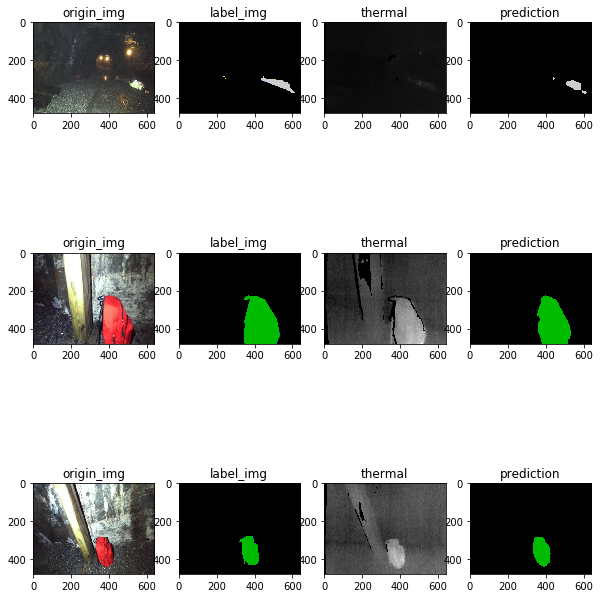

In [16]:
prediction("/home/alex/FCN-Pix2Pix-ERFNet_pytorch/models/ERFNet_dual_stream/ERFNet_batch3_epoch300_Adam_lr0.0005.pkl")

background: 0 , extinguisher: 1 , backpack: 2 , drill: 3 , survivor: 4